In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import bootstrap
from scipy.interpolate import interp1d

# Load Experimental data

In [2]:
# Load data
file_path = './'

file_CA   = file_path+'CA_coefficients.csv'
file_CN   = file_path+'CN_coefficients.csv'
file_CM   = file_path+'Cm_coefficients.csv'

data_CA = pd.read_csv(file_CA)
data_CN = pd.read_csv(file_CN)
data_CM = pd.read_csv(file_CM)

#data_CA.head()
#data_CN.head()
#data_CM.head()

# Load OpenFOAM solutions

In [3]:
# Load the data from the CSV file to inspect its contents
file_path = './reports.csv'
report = pd.read_csv(file_path)

# Display the 'OPENFOAM_WORKSPACE_DIR' column fully without truncation
pd.set_option('display.max_colwidth', None)

# Function to extract Mach number from the OPENFOAM_WORKSPACE_DIR column
def extract_mach_number(path):
    match = re.search(r'Ma(\d+\.\d+)', path)
    if match:
        return float(match.group(1))
    return None

# Apply the function to extract Mach number and create a new column for Mach
report['Mach'] = report['OPENFOAM_WORKSPACE_DIR'].apply(extract_mach_number)

# Drop rows where Mach could not be extracted
#report = report.dropna(subset=['Mach'])

# Function to extract grid refinement level (R1, R2, etc.) from the path
def extract_refinement_level(path):
    match = re.search(r'_R(\d)', path)
    if match:
        return f"R{match.group(1)}"
    return None

# Apply functions to create new columns for grid refinement
report['Grid_Refinement'] = report['OPENFOAM_WORKSPACE_DIR'].apply(extract_refinement_level)

# Function to extract angle of attack (AoA) from the path
def extract_aoa(path):
    match = re.search(r'AoA(\d+)', path)
    if match:
        return int(match.group(1))
    return None

# Apply functions to create new columns for AoA
report['AoA'] = report['OPENFOAM_WORKSPACE_DIR'].apply(extract_aoa)

# Extract solver names (rhoPimpleFoam or rhoCentralFoam) from 'OPENFOAM_WORKSPACE_DIR' column
report['Solver'] = report['OPENFOAM_WORKSPACE_DIR'].str.extract(r'(rhoPimpleFoam|rhoCentralFoam)')[0]

# Prepare markers and colors for distinguishing grid refinement levels and AoA
markersdict = {'R1': 'o', 'R2': 's', 'R3': '^', 'R4': 'D', 'R5': 'P'}
colors = {0: 'blue', 8: 'green', 10: 'red'}

# Display the first few rows of the data to understand its structure
report.to_csv('report_with_more_fields.csv', index=False)  
report

,OPENFOAM_WORKSPACE_DIR,YPLUS_MIN,YPLUS_MAX,YPLUS_AVG,CA_FINAL_COEFF,CN_FINAL_COEFF,CM_FINAL_COEFF,CA_FINAL_COEFF_WINDOW,CN_FINAL_COEFF_WINDOW,CM_FINAL_COEFF_WINDOW,...,residual_k,log.rhoCentralFoam,log.rhoPimpleFoam,residual_Uz,residual_omega,log.mapFields,Mach,Grid_Refinement,AoA,Solver
0,D:\sim\convergence_Ma0.6_AoA8_rhoPimpleFoam\Ma0.6_AoA8_R2_rhoPimpleFoam,0.000102,0.843450,0.264353,0.306690,0.310082,3.429177,0.306628,0.309873,3.428824,...,8.594039e-09,NaN,0.0,6.292154e-08,7.409846e-13,NaN,0.60,R2,8,rhoPimpleFoam
1,D:\sim\convergence_Ma0.6_AoA8_rhoPimpleFoam\Ma0.6_AoA8_R3_rhoPimpleFoam,0.005777,1.834531,0.485299,0.301450,0.294532,3.436073,0.301631,0.293805,3.435684,...,1.447199e-08,NaN,1.0,1.537637e-07,4.501601e-11,NaN,0.60,R3,8,rhoPimpleFoam
2,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R2_rhoPimpleFoam,0.000089,0.486806,0.151765,0.285508,-0.000611,-0.001517,0.284108,-0.000495,-0.001834,...,4.145121e-09,NaN,1.0,5.952972e-05,3.492564e-10,NaN,1.50,R2,0,rhoPimpleFoam
3,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R3_rhoPimpleFoam,0.001847,1.000567,0.323766,0.303084,0.000053,-0.008585,0.302357,-0.000304,-0.008323,...,4.831528e-09,NaN,1.0,6.818529e-05,5.776521e-12,NaN,1.50,R3,0,rhoPimpleFoam
4,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R4_rhoPimpleFoam,0.001864,1.061797,0.218455,0.307275,-0.000754,-0.006002,0.307007,-0.000907,-0.006942,...,6.360556e-09,NaN,1.0,4.915560e-05,4.677396e-12,NaN,1.50,R4,0,rhoPimpleFoam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,D:\sim\rhoPimpleFoam\R1\Ma2.3_AoA16_R1_rhoPimpleFoam,0.085951,66.353201,17.503139,0.350832,2.602437,12.602055,0.350854,2.602384,12.602385,...,4.286853e-08,NaN,1.0,4.154935e-07,3.698003e-10,NaN,2.30,R1,16,rhoPimpleFoam
70,D:\sim\rhoPimpleFoam\R1\Ma2.3_AoA8_R1_rhoPimpleFoam,0.087056,56.958329,17.523857,0.337326,0.577337,4.224774,0.337332,0.577567,4.224886,...,1.444832e-08,NaN,1.0,4.630210e-07,1.886851e-10,NaN,2.30,R1,8,rhoPimpleFoam
71,D:\sim\rhoPimpleFoam\R1\Ma4.63_AoA0_R1_rhoPimpleFoam,0.006824,44.326077,7.696415,0.180920,-0.000092,0.000360,0.180962,-0.000130,0.000112,...,6.866164e-10,NaN,0.0,7.248462e-06,8.197878e-12,NaN,4.63,R1,0,rhoPimpleFoam
72,D:\sim\rhoPimpleFoam\R1\Ma4.63_AoA16_R1_rhoPimpleFoam,0.024989,128.495757,9.155424,0.264325,2.772080,11.167811,0.264349,2.772100,11.166913,...,3.683666e-10,NaN,1.0,7.820306e-09,8.934831e-13,NaN,4.63,R1,16,rhoPimpleFoam


# Load DATCOM results

In [4]:
datcom = pd.read_csv("../DATCOM/MACH_ALPHA_CA_CN_CM.csv")
datcom

,MACH,ALPHA,CA,CN,CM
0,0.60,0.0,0.4010,0.0000,0.0000
1,0.60,8.0,0.3921,0.6220,6.3531
2,0.60,16.0,0.3599,1.3564,13.8061
3,1.00,0.0,0.5352,0.0000,0.0000
4,1.00,8.0,0.5308,0.6460,6.5916
5,1.00,16.0,0.5131,1.4998,15.2294
6,1.50,0.0,0.5152,0.0000,0.0000
7,1.50,8.0,0.4810,0.7374,7.4153
8,1.50,16.0,0.3808,1.8331,18.3780
9,2.30,0.0,0.3890,0.0000,0.0000


In [5]:
def plot_ca_vs_aoa_for_mach_numbers(file_path):
    
    # Load data
    data = pd.read_csv(file_path)
    
    # Extract the base name of the file (without directory or extension)
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    coefficient = base_name.split('_')
    
    # Extract and sort columns by Mach number
    sorted_columns = sorted([(float(col.split('_')[0][1:]), col) for col in data.columns[1:]])
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    # Loop through the sorted Mach number columns
    for mach, column in sorted_columns:
        # Extract AoA and corresponding CA values, removing NaNs
        aoa = data['AoA']
        ca_values = data[column]
        
        # Plot only if there are valid data points
        if ca_values.notna().any():
            plt.plot(aoa, ca_values, label=f"M{mach}")

    # Add labels and title
    plt.xlabel('Angle of Attack (AoA)', fontsize=16)
    plt.ylabel(coefficient[0]+' Coefficient', fontsize=16)
    plt.title(coefficient[0]+' Coefficient vs. AoA for Various Mach Numbers')
    plt.grid(True)
    plt.legend(title='Mach Numbers', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout for better viewing
    plt.tight_layout()
    
    # Save the plot with filenames that include the base name of the input file
    plt.savefig(f"{coefficient[0]}_vs_alpha.png")
    plt.savefig(f"{coefficient[0]}_vs_alpha.eps")
    plt.savefig(f"{coefficient[0]}_vs_alpha.pdf")
    
    # Show plot
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


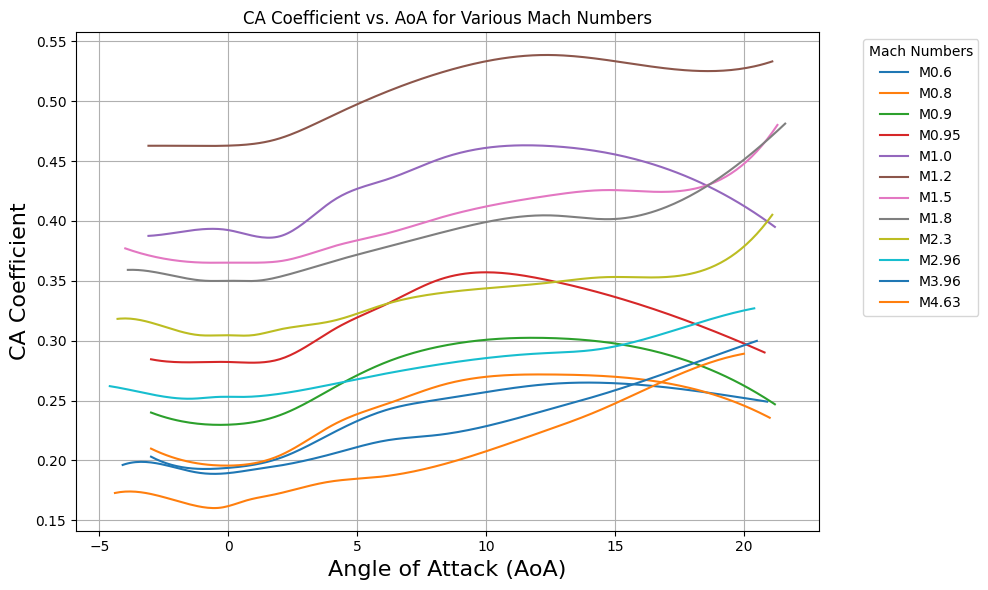

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


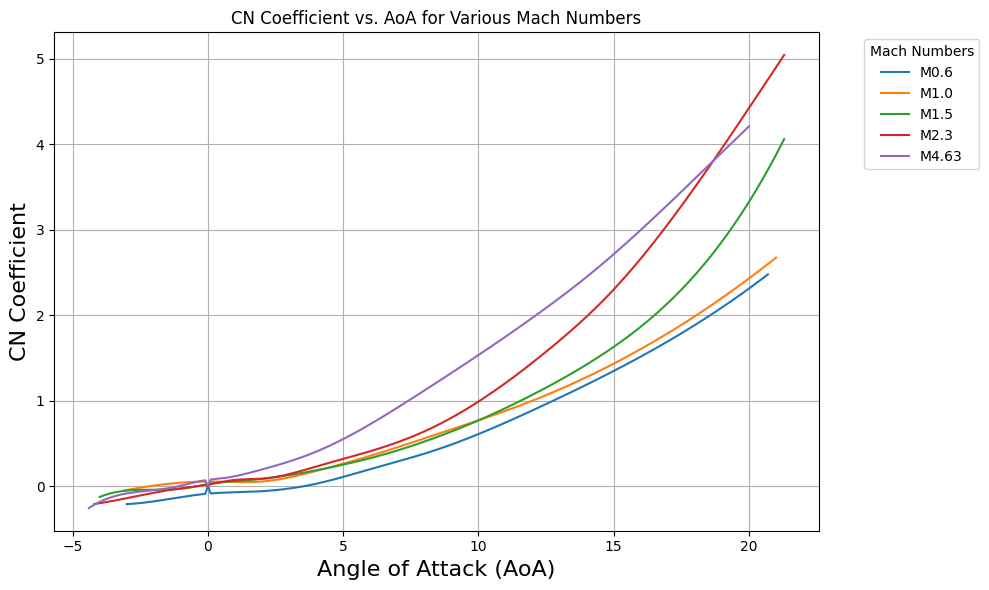

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


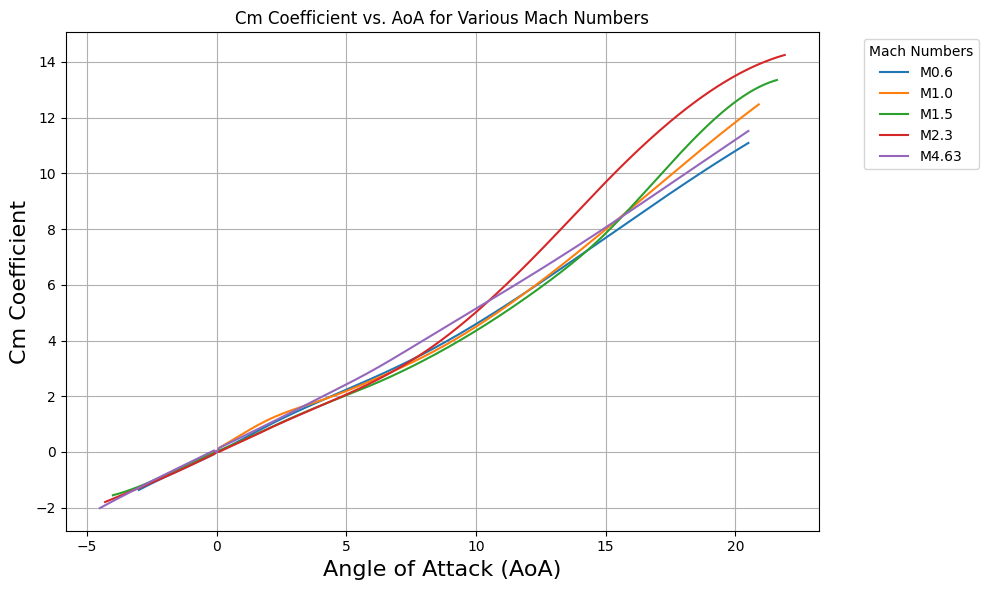

In [6]:
plot_ca_vs_aoa_for_mach_numbers(file_CA)
plot_ca_vs_aoa_for_mach_numbers(file_CN)
plot_ca_vs_aoa_for_mach_numbers(file_CM)

In [7]:
# def plot_coefficient_vs_mach(file_path, angle):
    
#     # Load data
#     data = pd.read_csv(file_path)
#     data = data[data['AoA'] == angle]
    
#     # Check if data is available for that alpha
#     if data.empty:
#         print("No data found for alpha = ", angle)
#         return

#     #unique_aoa = data['AoA'].dropna().unique()
#     #selected_aoa_values = unique_aoa[80:81]
#     #ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:] # Select the row for the AoA and skip the 'AoA' column
#     ca_values = data['AoA']
#     ca_values = ca_values.values
    
#     mach_numbers   = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
#     sorted_indices = np.argsort(mach_numbers)
#     mach_numbers   = np.array(mach_numbers)[sorted_indices]
#     #ca_values      = ca_values[sorted_indices]

#     plt.figure(figsize=(16, 10))
#     plt.plot(mach_numbers, ca_values, marker='o', linestyle='-.', color='k', label='EXP.')
#     plt.xlabel('Mach Number', fontsize=22)
#     plt.ylabel('$C_A$ Coefficient', fontsize=22)
#     plt.title(f'$C_A$ Coefficients at AoA = {aoa_value}°', fontsize=22)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.legend()
#     plt.savefig(f"CA_alpha_{aoa_value}.png")
#     plt.savefig(f"CA_alpha_{aoa_value}.eps")
#     plt.savefig(f"CA_alpha_{aoa_value}.pdf")    
#     plt.show()

In [8]:
# Function to find indices where AoA equals the selected value
def find_aoa_index(df, selected_value):
    indices = df.index[df['AoA'] == selected_value].tolist() 
    data    = df.iloc[indices]
    return indices, data

# Output the result
#if indices:
#    print(f"Indices where AoA is equal to {selected_value}: {indices}")
#else:
#    print(f"No indices found for AoA equal to {selected_value}.")

<div style="border: 1px solid black; padding: 20px; display: flex; justify-content: center; align-items: center; text-align: center;">
    <strong style="font-size: 24px;"> $C_A$ coefficient</strong>
</div>

## $C_A$ coefficient for $\alpha$ = 0$^\circ$ as function of Mach number

In [9]:
AoA           = 0.0 
indices, data = find_aoa_index(data_CA, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

data

,AoA,M0.6_CA-ALPHA,M0.8_CA-ALPHA,M0.9_CA-ALPHA,M0.95_CA-ALPHA,M1.0_CA-ALPHA,M1.2_CA-ALPHA,M1.5_CA-ALPHA,M1.8_CA-ALPHA,M2.3_CA-ALPHA,M2.96_CA-ALPHA,M3.96_CA-ALPHA,M4.63_CA-ALPHA
80,0.0,0.193765,0.195659,0.22982,0.282203,0.392326,0.462855,0.365148,0.349996,0.304512,0.253126,0.189394,0.161852


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


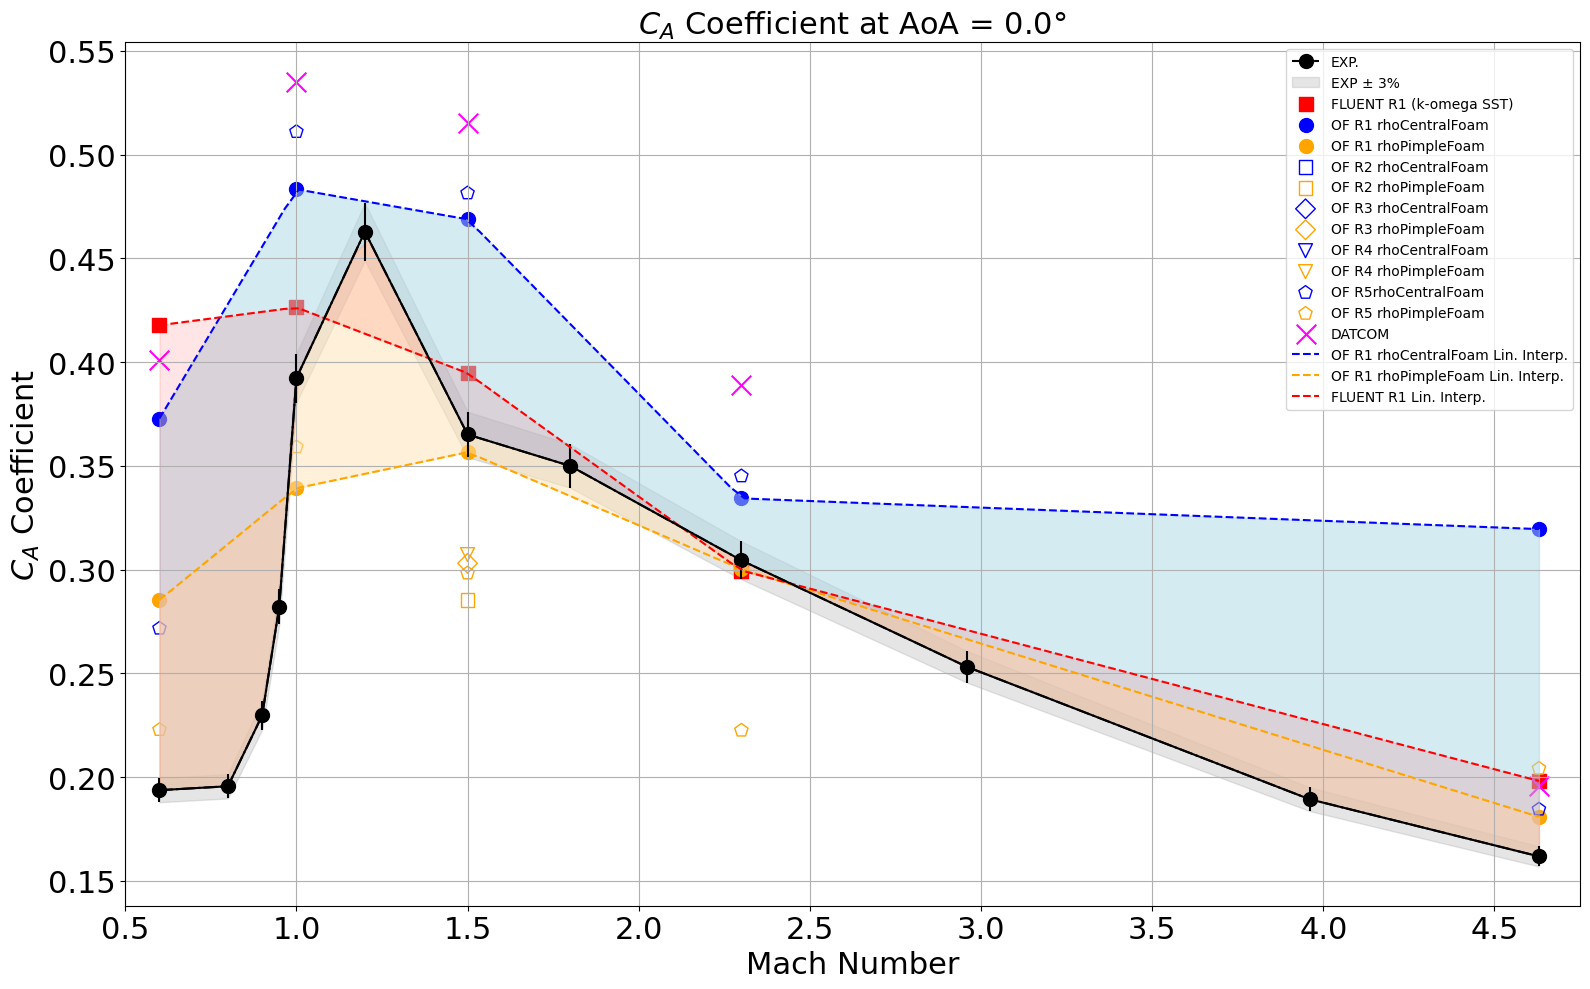

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


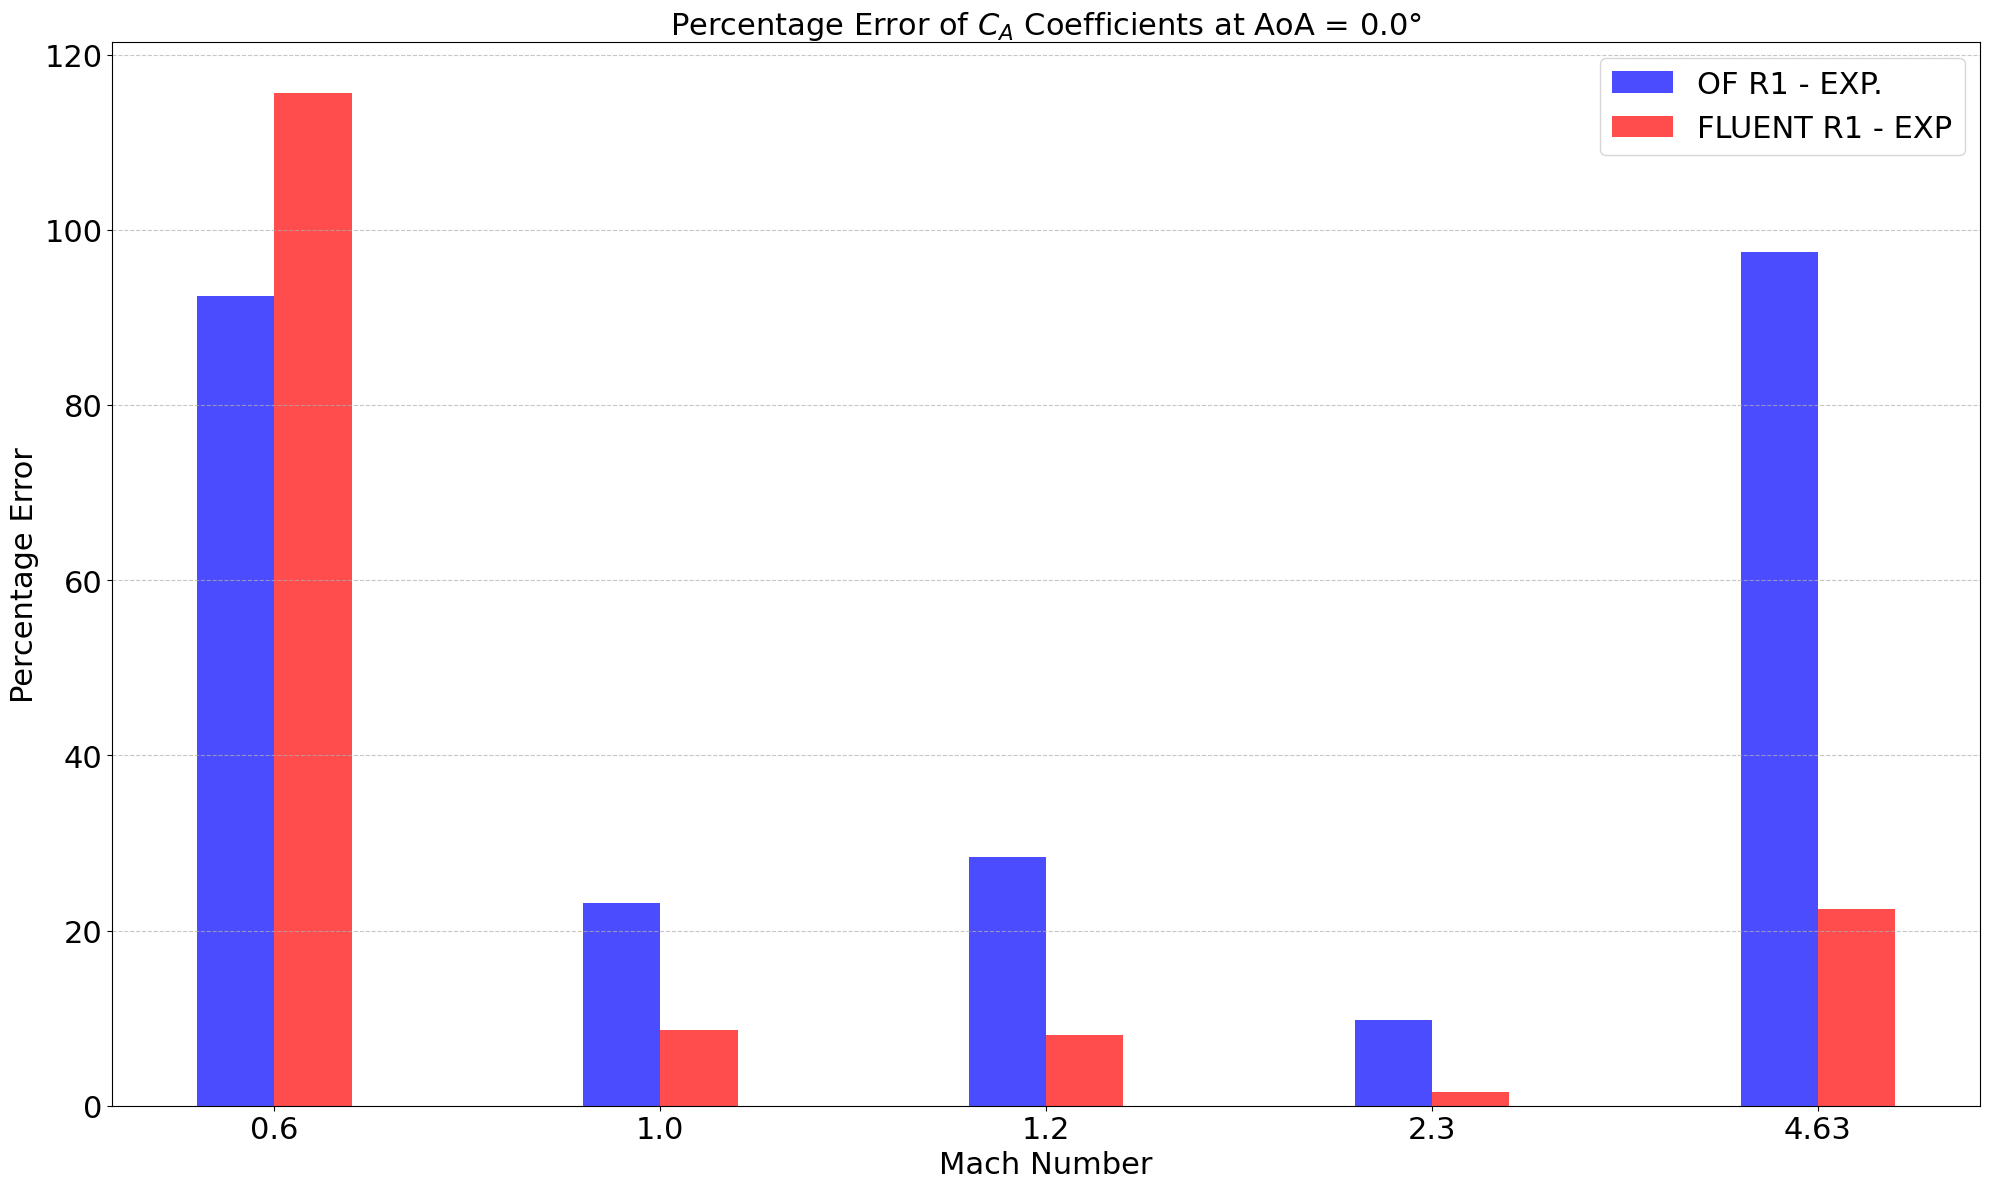

In [11]:
plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_A$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Self-extracted OF data
#OF_data = {
#    0.6:  [0.272, 0.373],  
#    1.0:  [0.511, 0.483],  
#    1.5:  [0.481, 0.469],  
#    2.3:  [0.345, 0.334],  
#    4.63: [0.185, 0.320]  
#}
#OF_mach_numbers = list(OF_data.keys())
#CA_values_R5 = [values[0] for values in OF_data.values()]  
#CA_values_R1 = [values[1] for values in OF_data.values()]  
#plt.scatter(OF_mach_numbers, CA_values_R1, facecolors='none', s=200, label='OF R1 rhoCentralFoam', color='blue')
#plt.scatter(OF_mach_numbers, CA_values_R5, facecolors='none', s=200, label='OF R5 rhoCentralFoam', color='orange')

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [0.4178,0.4178,0.4178,0.4178,0.4178], # Corresponds to R1, R2, R3, R4, R5
        1.0:  [0.4264,0.4199,0.4178,0.4178,0.4178],
        1.5:  [0.3947,0.3947,0.4178,0.4178,0.4178],
        2.3:  [0.2996,0.2996,0.4178,0.4178,0.4178],
        4.63: [0.1982,0.1982,0.4178,0.4178,0.4178]
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CA_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CA_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CA_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CA_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CA_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CA_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CA_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CA'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CA_alpha_{AoA}.png")
plt.savefig(f"CA_alpha_{AoA}.eps")
plt.savefig(f"CA_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

ccoefficients = coefficients[[0,4,6,8,11]]
cmach_numbers = [mach_numbers[0], mach_numbers[4], mach_numbers[5], mach_numbers[8], mach_numbers[11]]

# Calculate percentage error between EXP. and OF (rhoCentralFoam)
OF_percentage_error_R1 = np.abs(ccoefficients - (OF_R1_rhoCentralFoam['CA_FINAL_COEFF'])) / np.abs(ccoefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CA_FINAL_COEFF']) / np.abs(coefficients) * 100

# Calculate percentage error between EXP. and FLUENT
FLUENT_percentage_error_R1 = np.abs(ccoefficients - coeff_R1) / np.abs(ccoefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2       
x = np.arange(len(cmach_numbers))

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_A$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, cmach_numbers) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CA_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CA_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CA_PercentageError_alpha_{AoA}.pdf")
plt.show()

## $C_A$ coefficient for $\alpha$ = 8$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


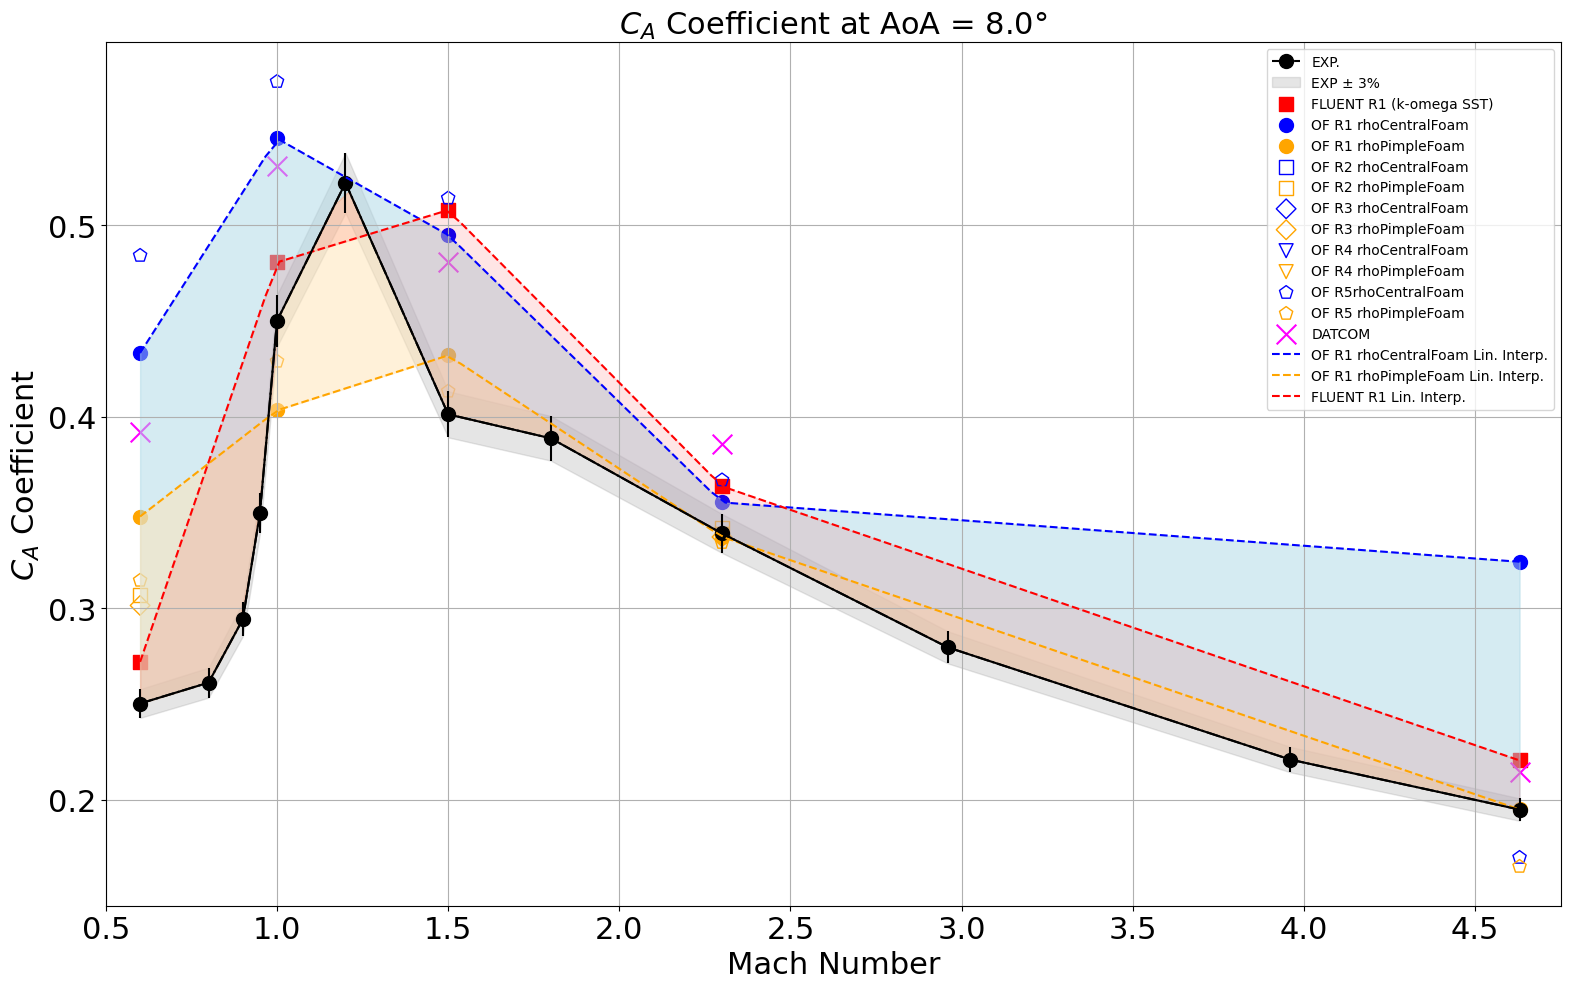

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


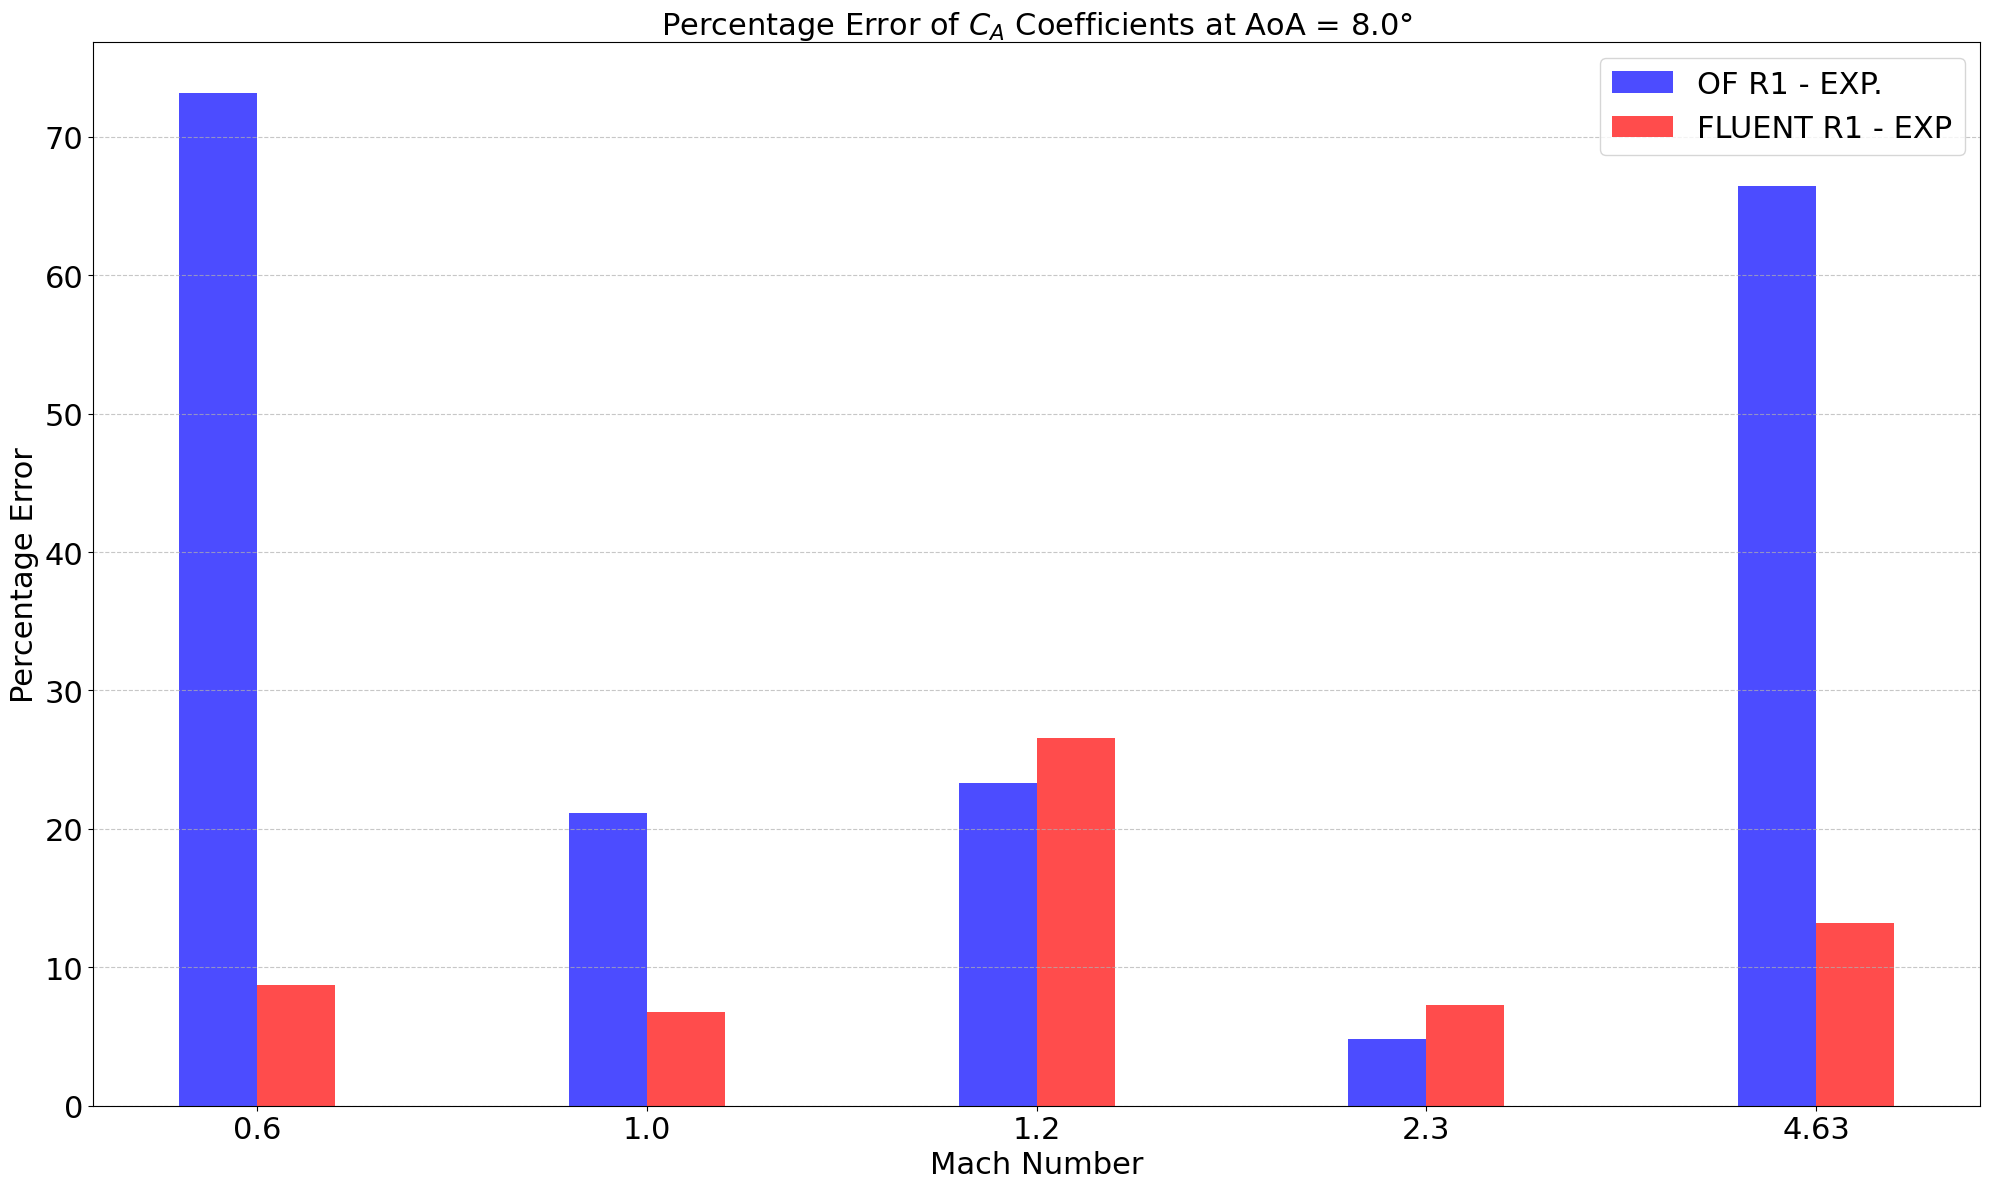

In [13]:
AoA           = 8.0 
indices, data = find_aoa_index(data_CA, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_A$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [0.272,  0.373,  0,0,0],  
        1.0:  [0.4807, 0.4807, 0,0,0], 
        1.5:  [0.5080, 0.5080, 0,0,0], 
        2.3:  [0.3637, 0.3637, 0,0,0], 
        4.63: [0.2205, 0.2205, 0,0,0] 
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CA_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CA_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CA_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CA_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CA_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CA_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CA_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CA'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CA_alpha_{AoA}.png")
plt.savefig(f"CA_alpha_{AoA}.eps")
plt.savefig(f"CA_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

ccoefficients = coefficients[[0,4,6,8,11]]
cmach_numbers = [mach_numbers[0], mach_numbers[4], mach_numbers[5], mach_numbers[8], mach_numbers[11]]

# Calculate percentage error between EXP. and OF (rhoCentralFoam)
OF_percentage_error_R1 = np.abs(ccoefficients - (OF_R1_rhoCentralFoam['CA_FINAL_COEFF'])) / np.abs(ccoefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CA_FINAL_COEFF']) / np.abs(coefficients) * 100

# Calculate percentage error between EXP. and FLUENT
FLUENT_percentage_error_R1 = np.abs(ccoefficients - coeff_R1) / np.abs(ccoefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(cmach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_A$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, cmach_numbers) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CA_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CA_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CA_PercentageError_alpha_{AoA}.pdf")
plt.show()

## $C_A$ coefficient for $\alpha$ = 16$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


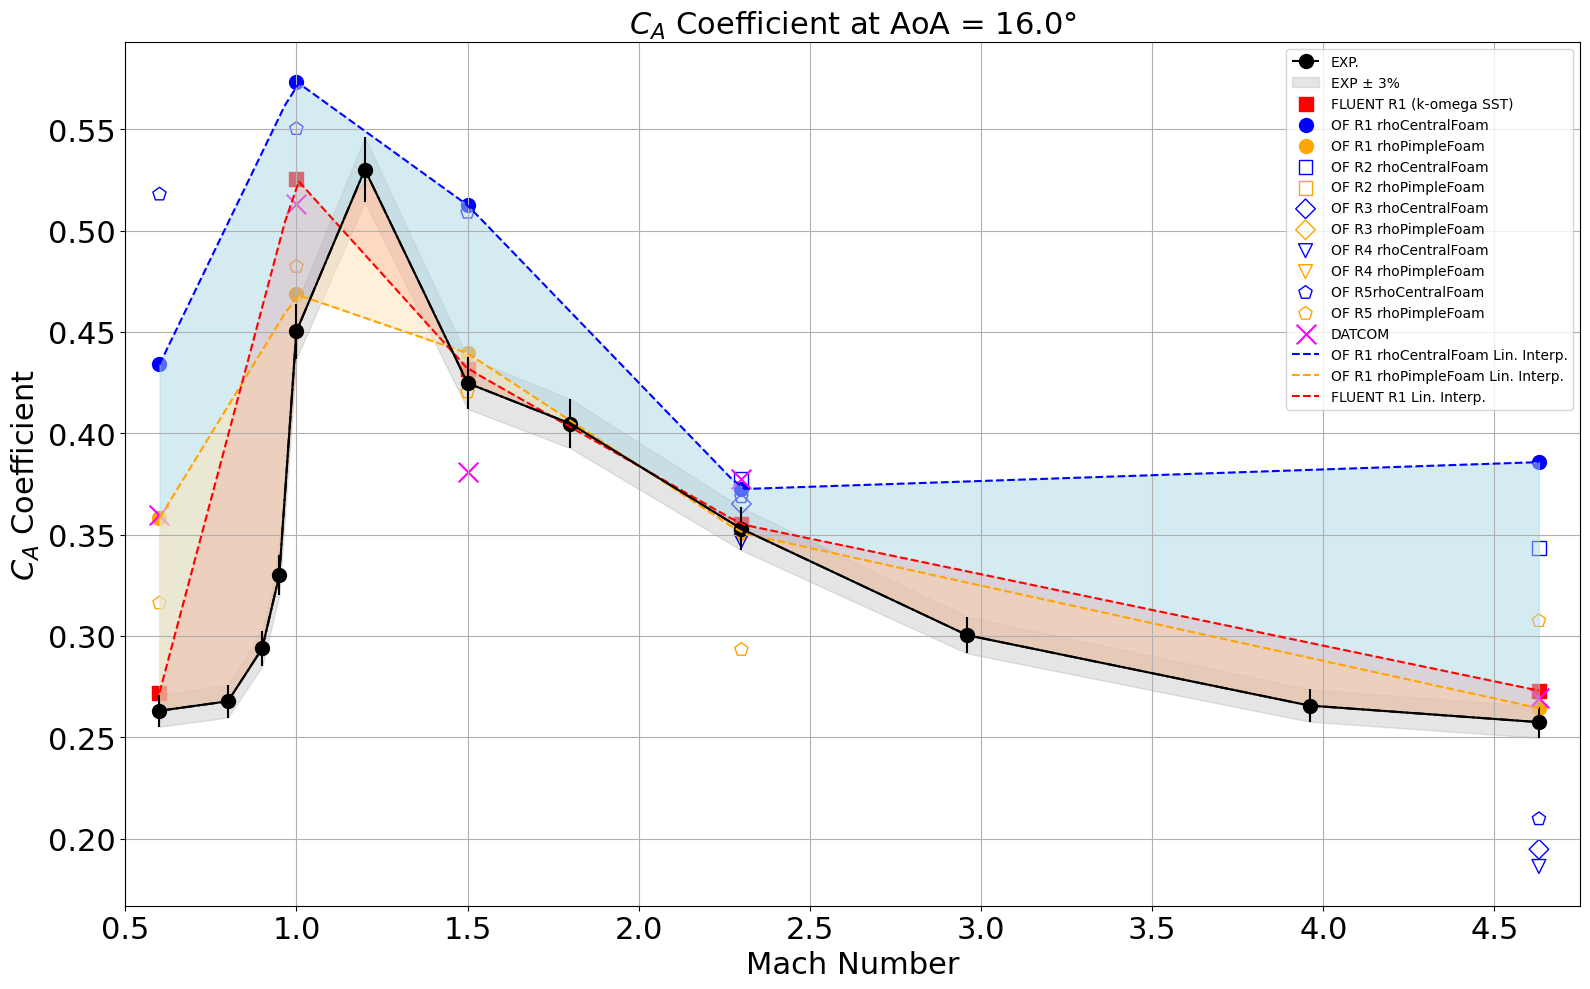

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


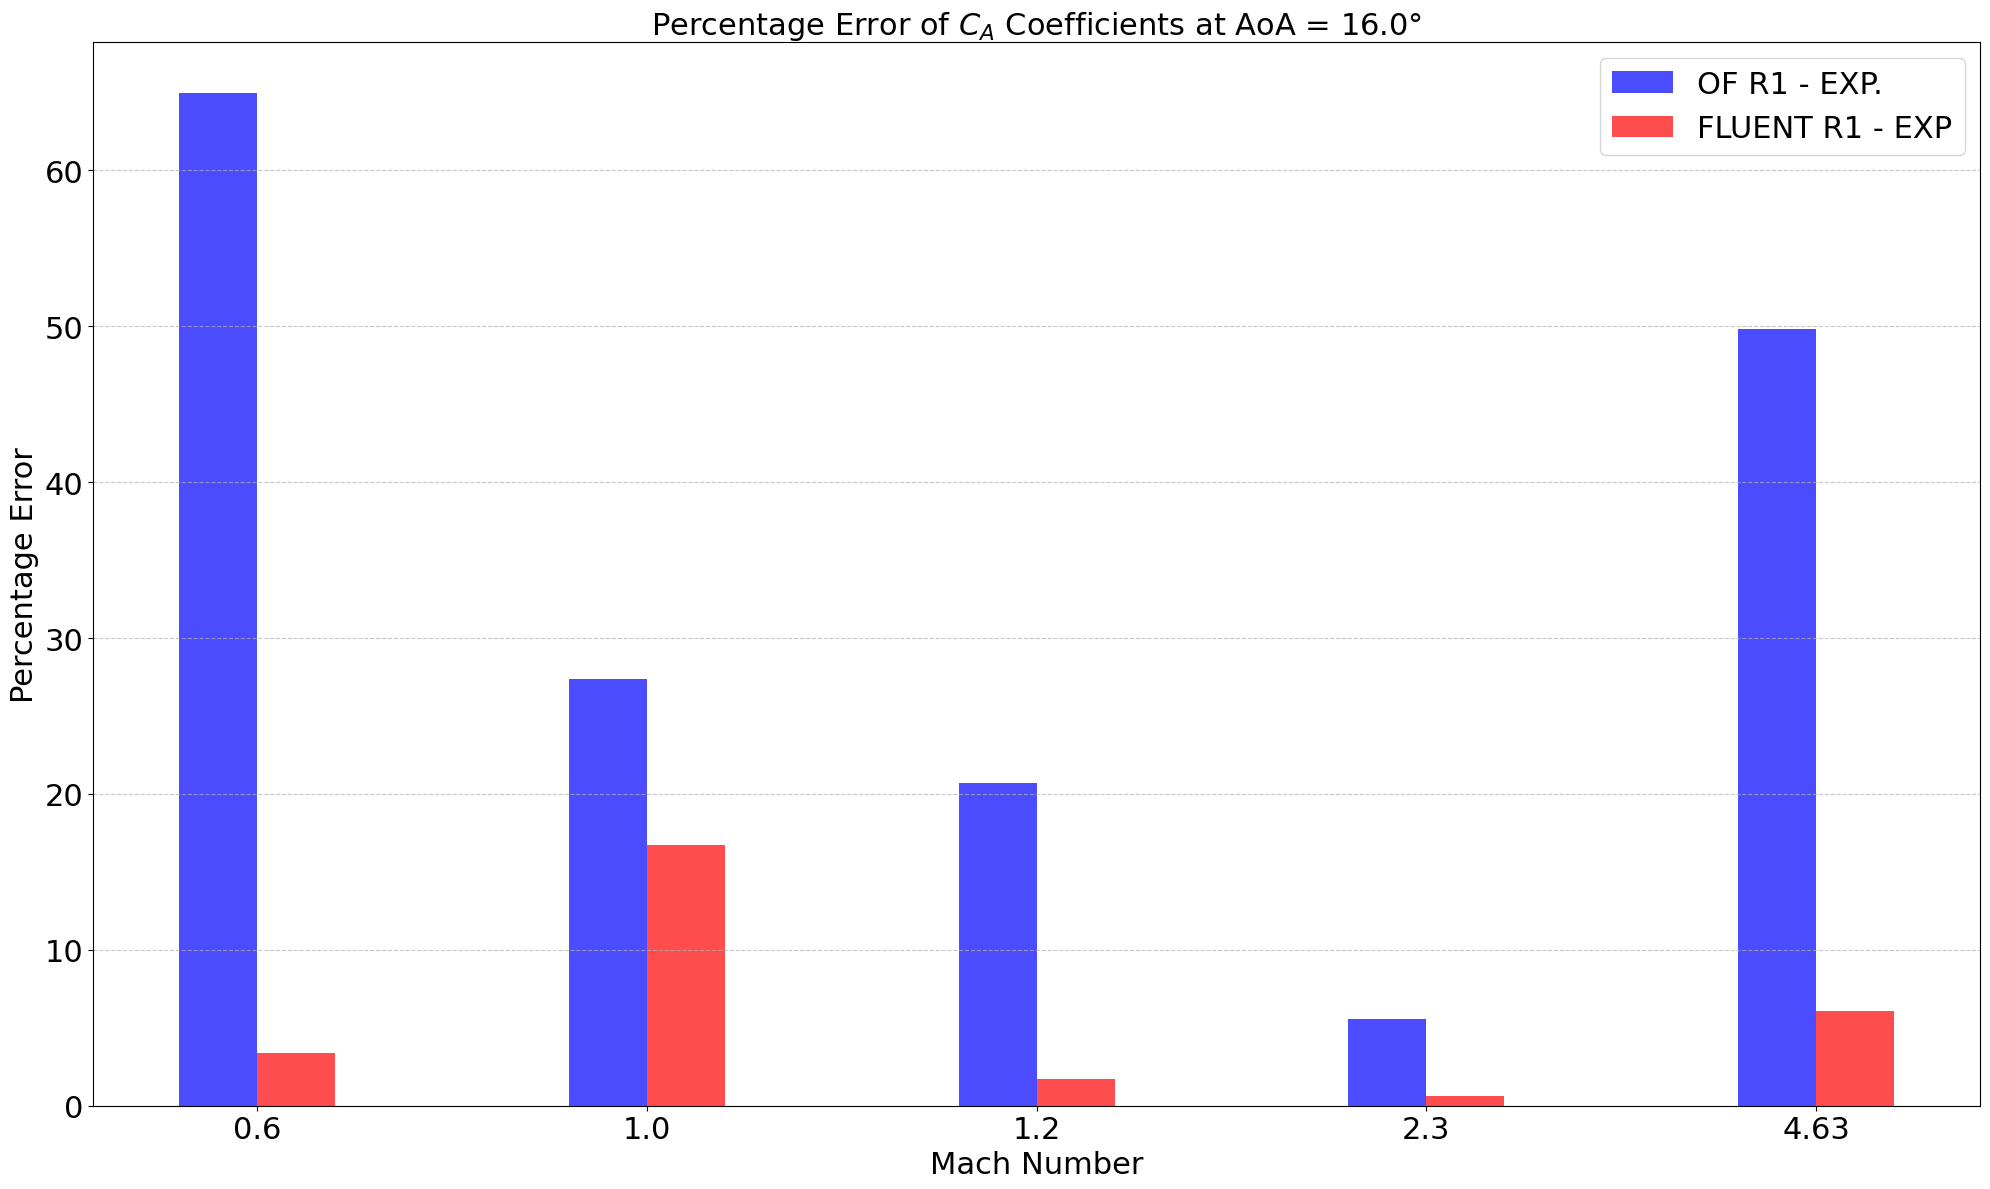

In [14]:
AoA           = 16.0 
indices, data = find_aoa_index(data_CA, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_A$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [0.272,  0.373,  0.0, 0.0, 0.0],  
        1.0:  [0.5256, 0.0000, 0.0, 0.0, 0.0], 
        1.5:  [0.4319, 0.4319, 0.0, 0.0, 0.0],
        2.3:  [0.3551, 0.3693, 0.370, 0.0, 0.0], 
        4.63: [0.2730, 0.2730, 0.0, 0.0, 0.0]  
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CA_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CA_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CA_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CA_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CA_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CA_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CA_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CA_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')


# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CA'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CA_alpha_{AoA}.png")
plt.savefig(f"CA_alpha_{AoA}.eps")
plt.savefig(f"CA_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

ccoefficients = coefficients[[0,4,6,8,11]]
cmach_numbers = [mach_numbers[0], mach_numbers[4], mach_numbers[5], mach_numbers[8], mach_numbers[11]]

# Calculate percentage error between EXP. and OF (rhoCentralFoam)
OF_percentage_error_R1 = np.abs(ccoefficients - (OF_R1_rhoCentralFoam['CA_FINAL_COEFF'])) / np.abs(ccoefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CA_FINAL_COEFF']) / np.abs(coefficients) * 100

# Calculate percentage error between EXP. and FLUENT
FLUENT_percentage_error_R1 = np.abs(ccoefficients - coeff_R1) / np.abs(ccoefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(cmach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_A$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, cmach_numbers) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CA_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CA_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CA_PercentageError_alpha_{AoA}.pdf")
plt.show()

<div style="border: 1px solid black; padding: 20px; display: flex; justify-content: center; align-items: center; text-align: center;">
    <strong style="font-size: 24px;"> $C_N$ coefficient</strong>
</div>

## $C_N$ coefficient for $\alpha$ = 0$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


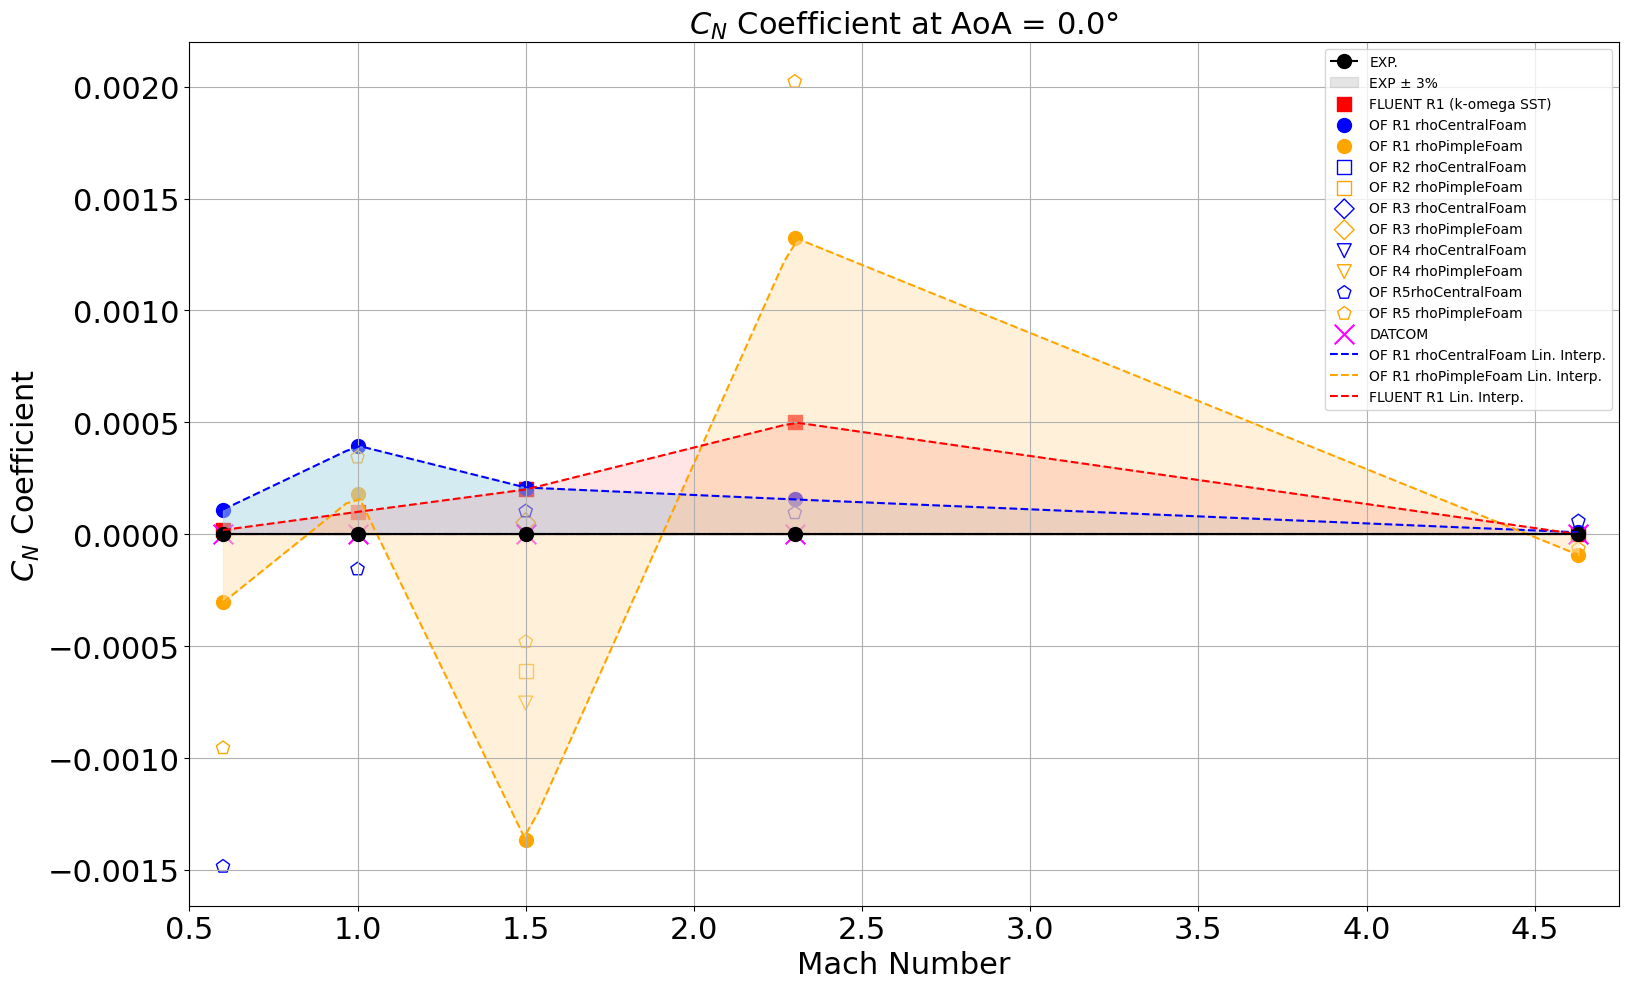

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


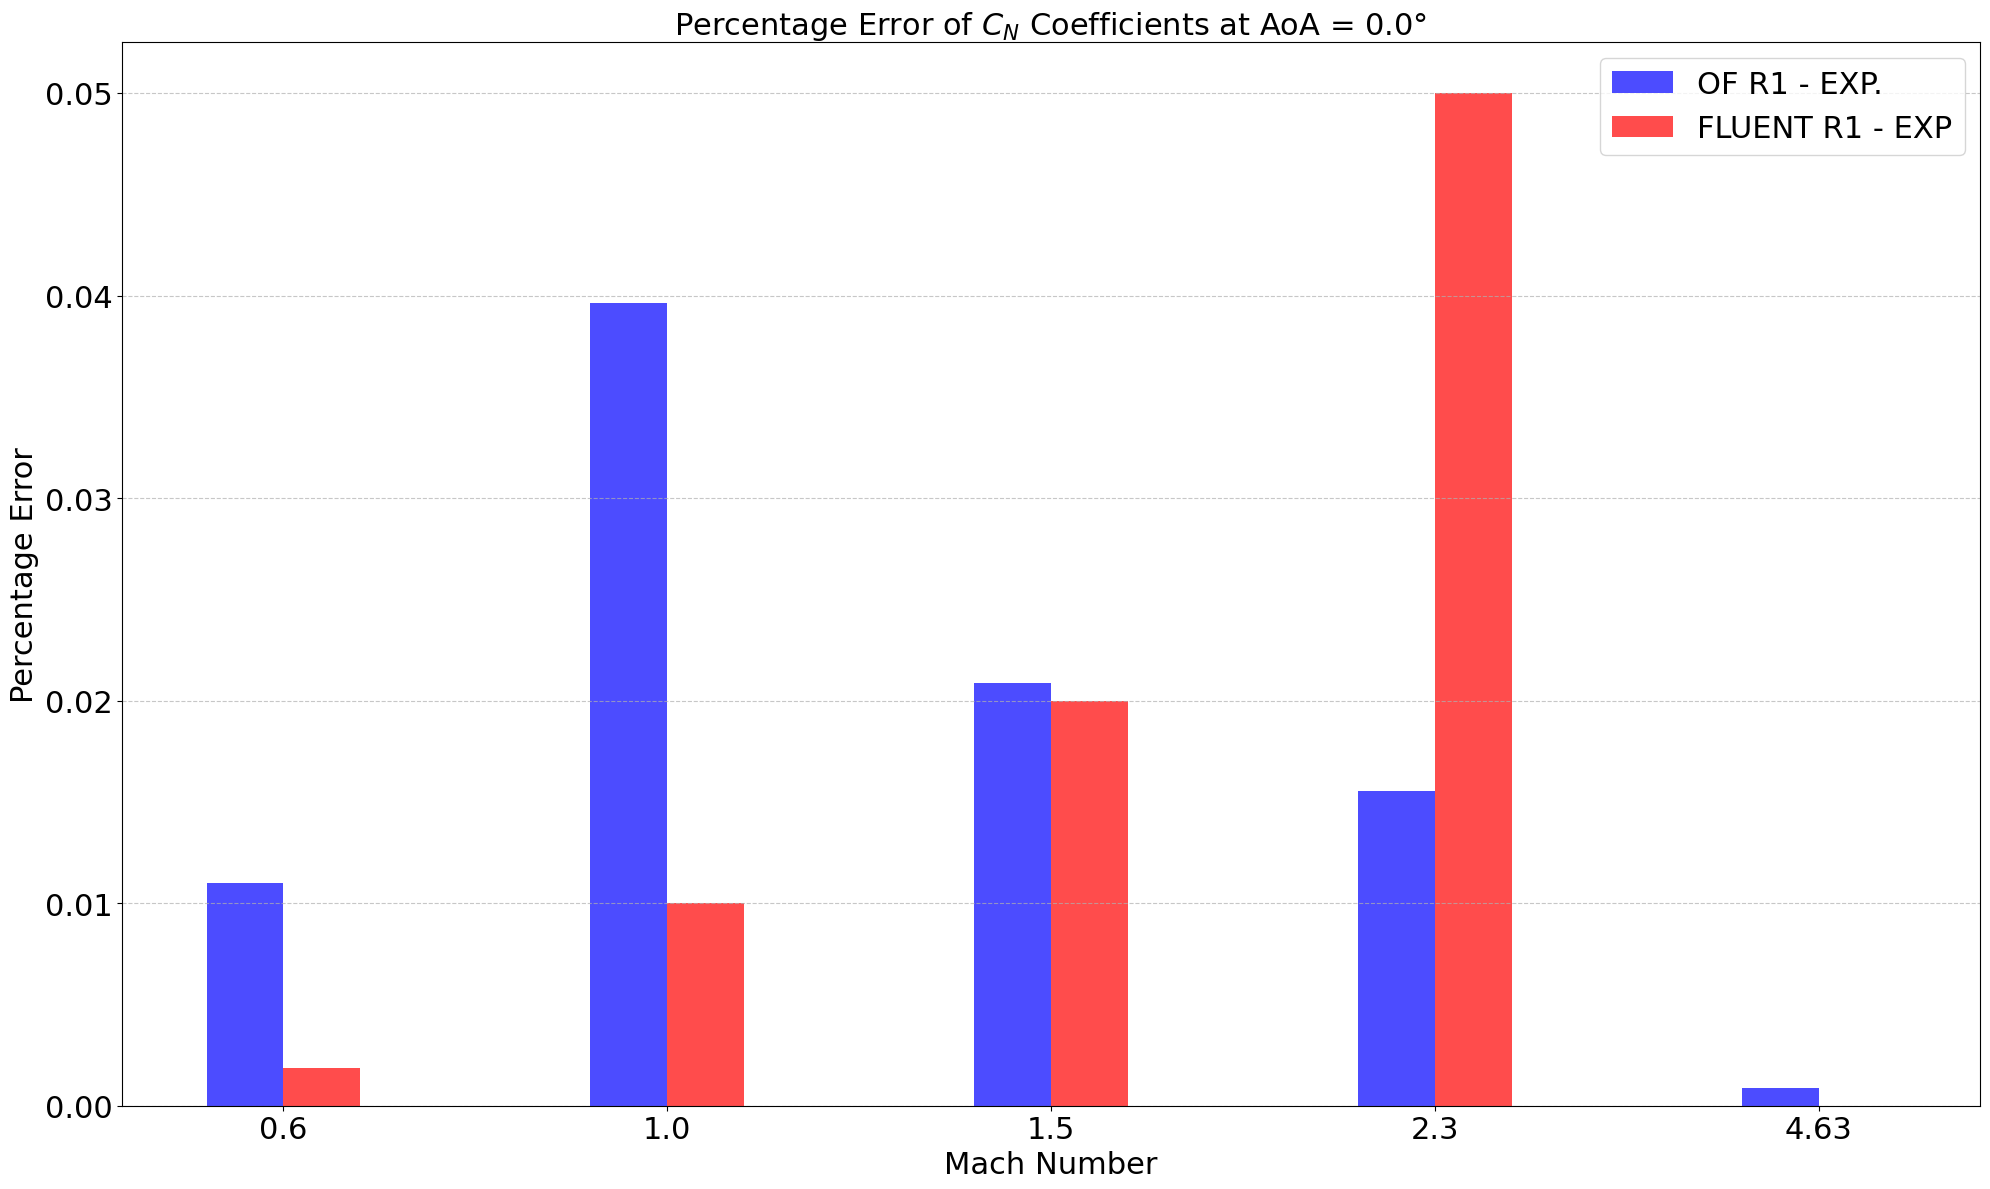

In [15]:
AoA           = 0.0
indices, data = find_aoa_index(data_CN, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_N$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_N$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [0.0000188, 0.0000188, 0,0,0], 
        1.0:  [0.0001,0.0000, 0,0,0],
        1.5:  [0.0002,0.0002, 0,0,0],
        2.3:  [0.0005,0.0005, 0,0,0],
        4.63: [0.0,0.0, 0,0,0]  
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CN_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CN_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CN_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CN_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CN_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CN_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CN_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CN'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CN_alpha_{AoA}.png")
plt.savefig(f"CN_alpha_{AoA}.eps")
plt.savefig(f"CN_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

eps = 1
#ccoefficients = coefficients[[0,4,6,8,11]]
#cmach_numbers = [mach_numbers[0], mach_numbers[4], mach_numbers[5], mach_numbers[8], mach_numbers[11]]

# Calculate percentage error between EXP. and OF (rhoCentralFoam)
OF_percentage_error_R1 = np.abs(coefficients - (OF_R1_rhoCentralFoam['CN_FINAL_COEFF'])) / np.abs(coefficients+eps) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CN_FINAL_COEFF']) / np.abs(coefficients) * 100

# Calculate percentage error between EXP. and FLUENT
FLUENT_percentage_error_R1 = np.abs(coefficients - coeff_R1) / np.abs(coefficients+eps) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(mach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

# Axes labels, title, and ticks
plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_N$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
#plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CN_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CN_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CN_PercentageError_alpha_{AoA}.pdf")
plt.show()

## $C_N$ coefficient for $\alpha$ = 8$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


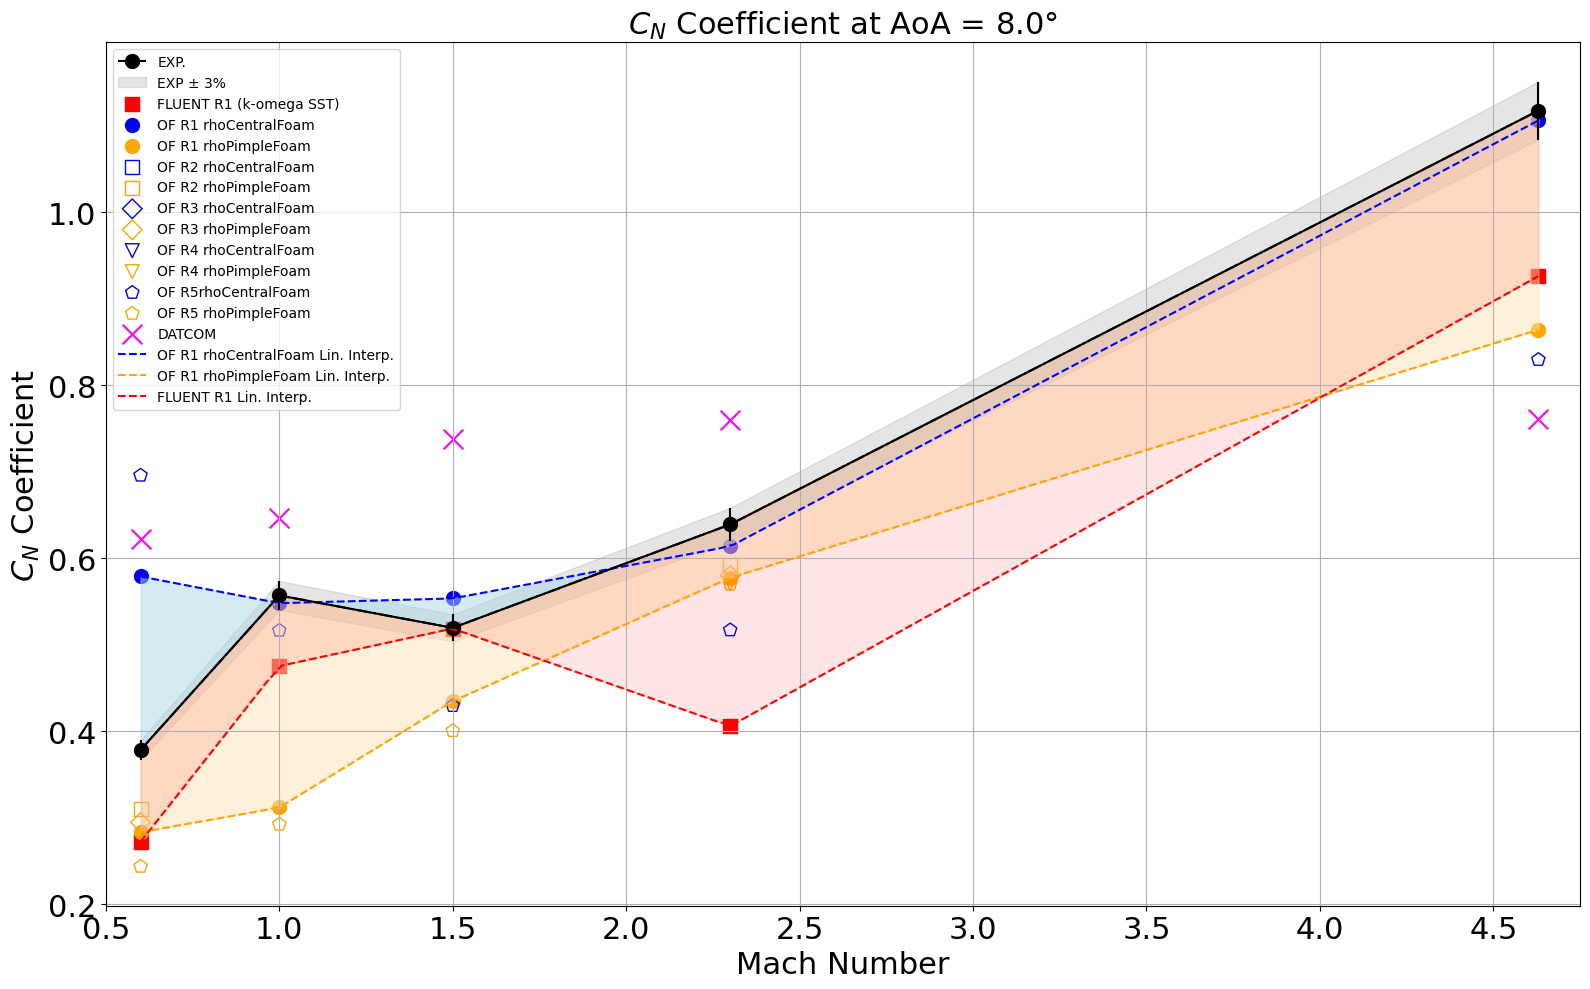

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


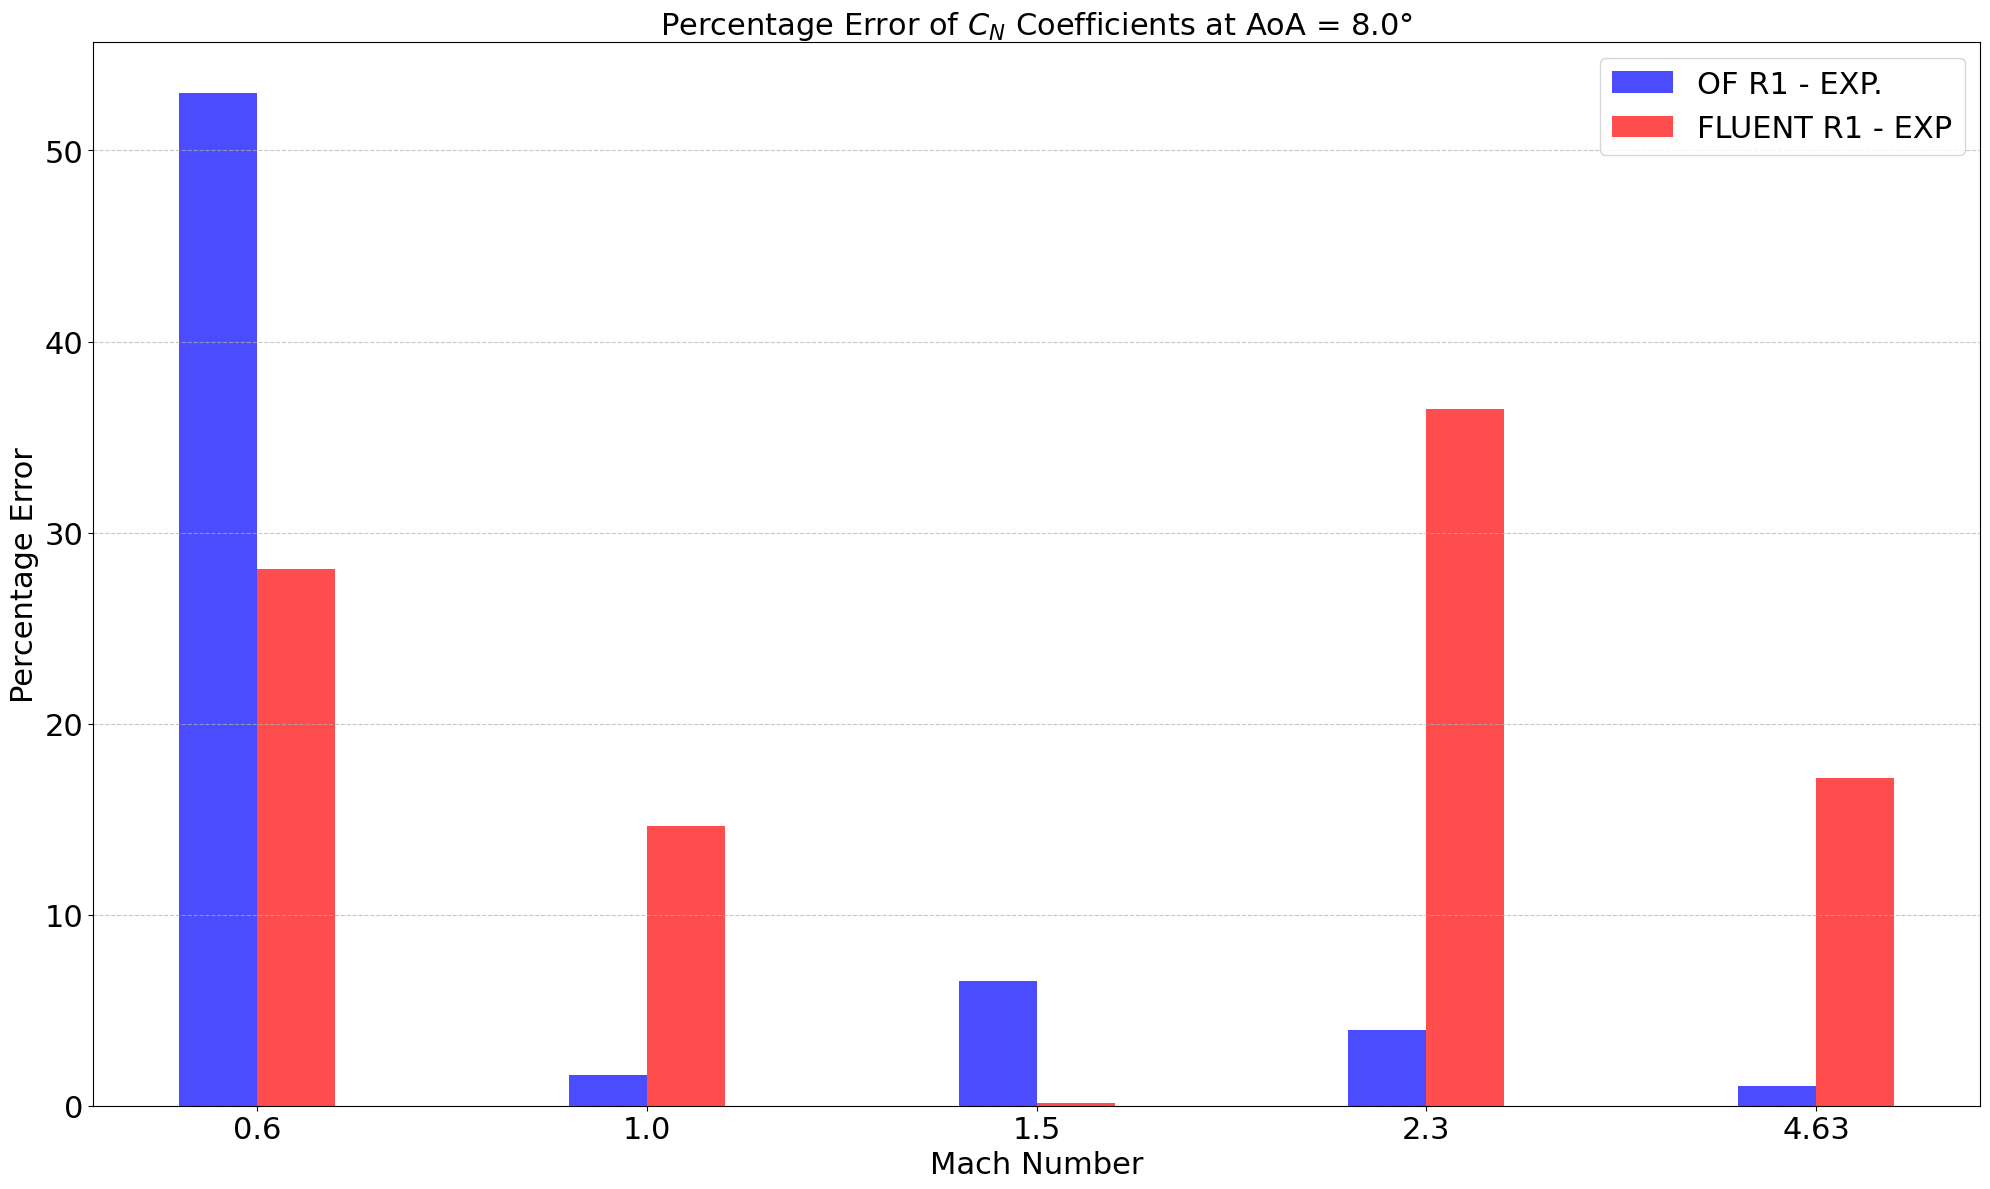

In [16]:
AoA           = 8.0
indices, data = find_aoa_index(data_CN, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_N$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_N$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6: [0.272, 0.373, 0,0,0],  
        1.0: [0.4752, 0.4752, 0,0,0], 
        1.5: [0.5186, 0.5186, 0,0,0], 
        2.3: [0.4058, 0.4058, 0,0,0], 
        4.63: [0.9259, 0.9259, 0,0,0] 
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CN_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CN_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CN_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CN_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CN_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CN_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CN_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CN'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CN_alpha_{AoA}.png")
plt.savefig(f"CN_alpha_{AoA}.eps")
plt.savefig(f"CN_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

# Calculate percentage error margins
OF_percentage_error_R1 = np.abs(coefficients - OF_R1_rhoCentralFoam['CN_FINAL_COEFF']) / np.abs(coefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CN_FINAL_COEFF']) / np.abs(coefficients) * 100

FLUENT_percentage_error_R1 = np.abs(coefficients - coeff_R1) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(mach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

# Axes labels, title, and ticks
plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_N$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
#plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CN_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CN_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CN_PercentageError_alpha_{AoA}.pdf")
plt.show()

## $C_N$ coefficient for $\alpha$ = 16$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


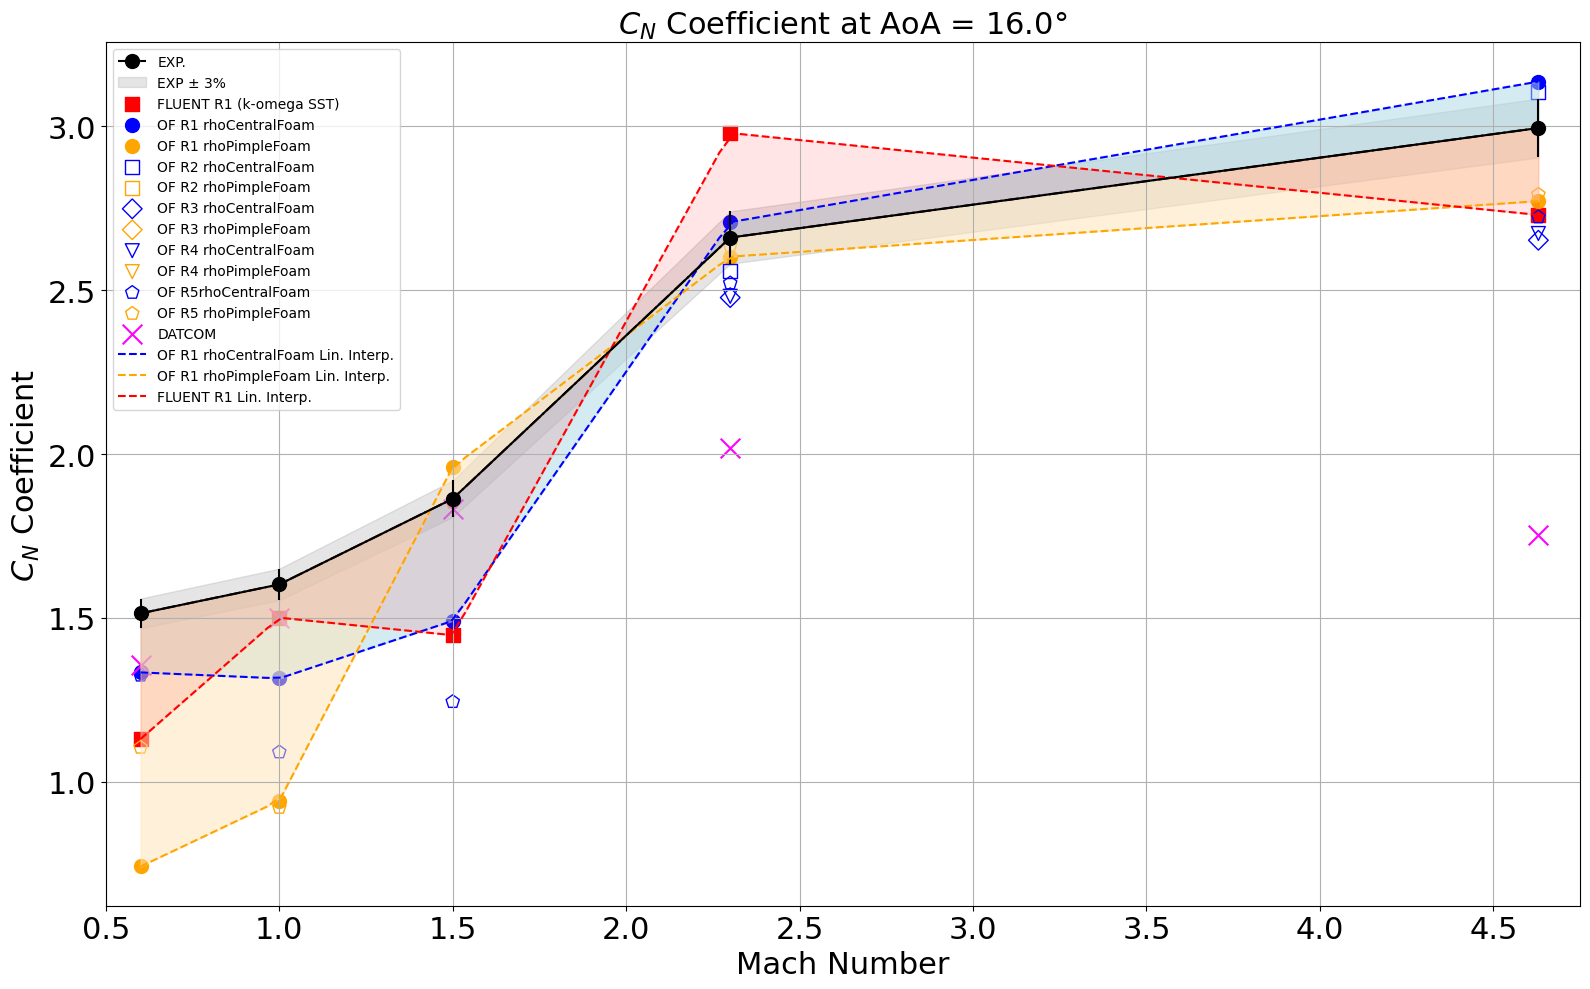

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


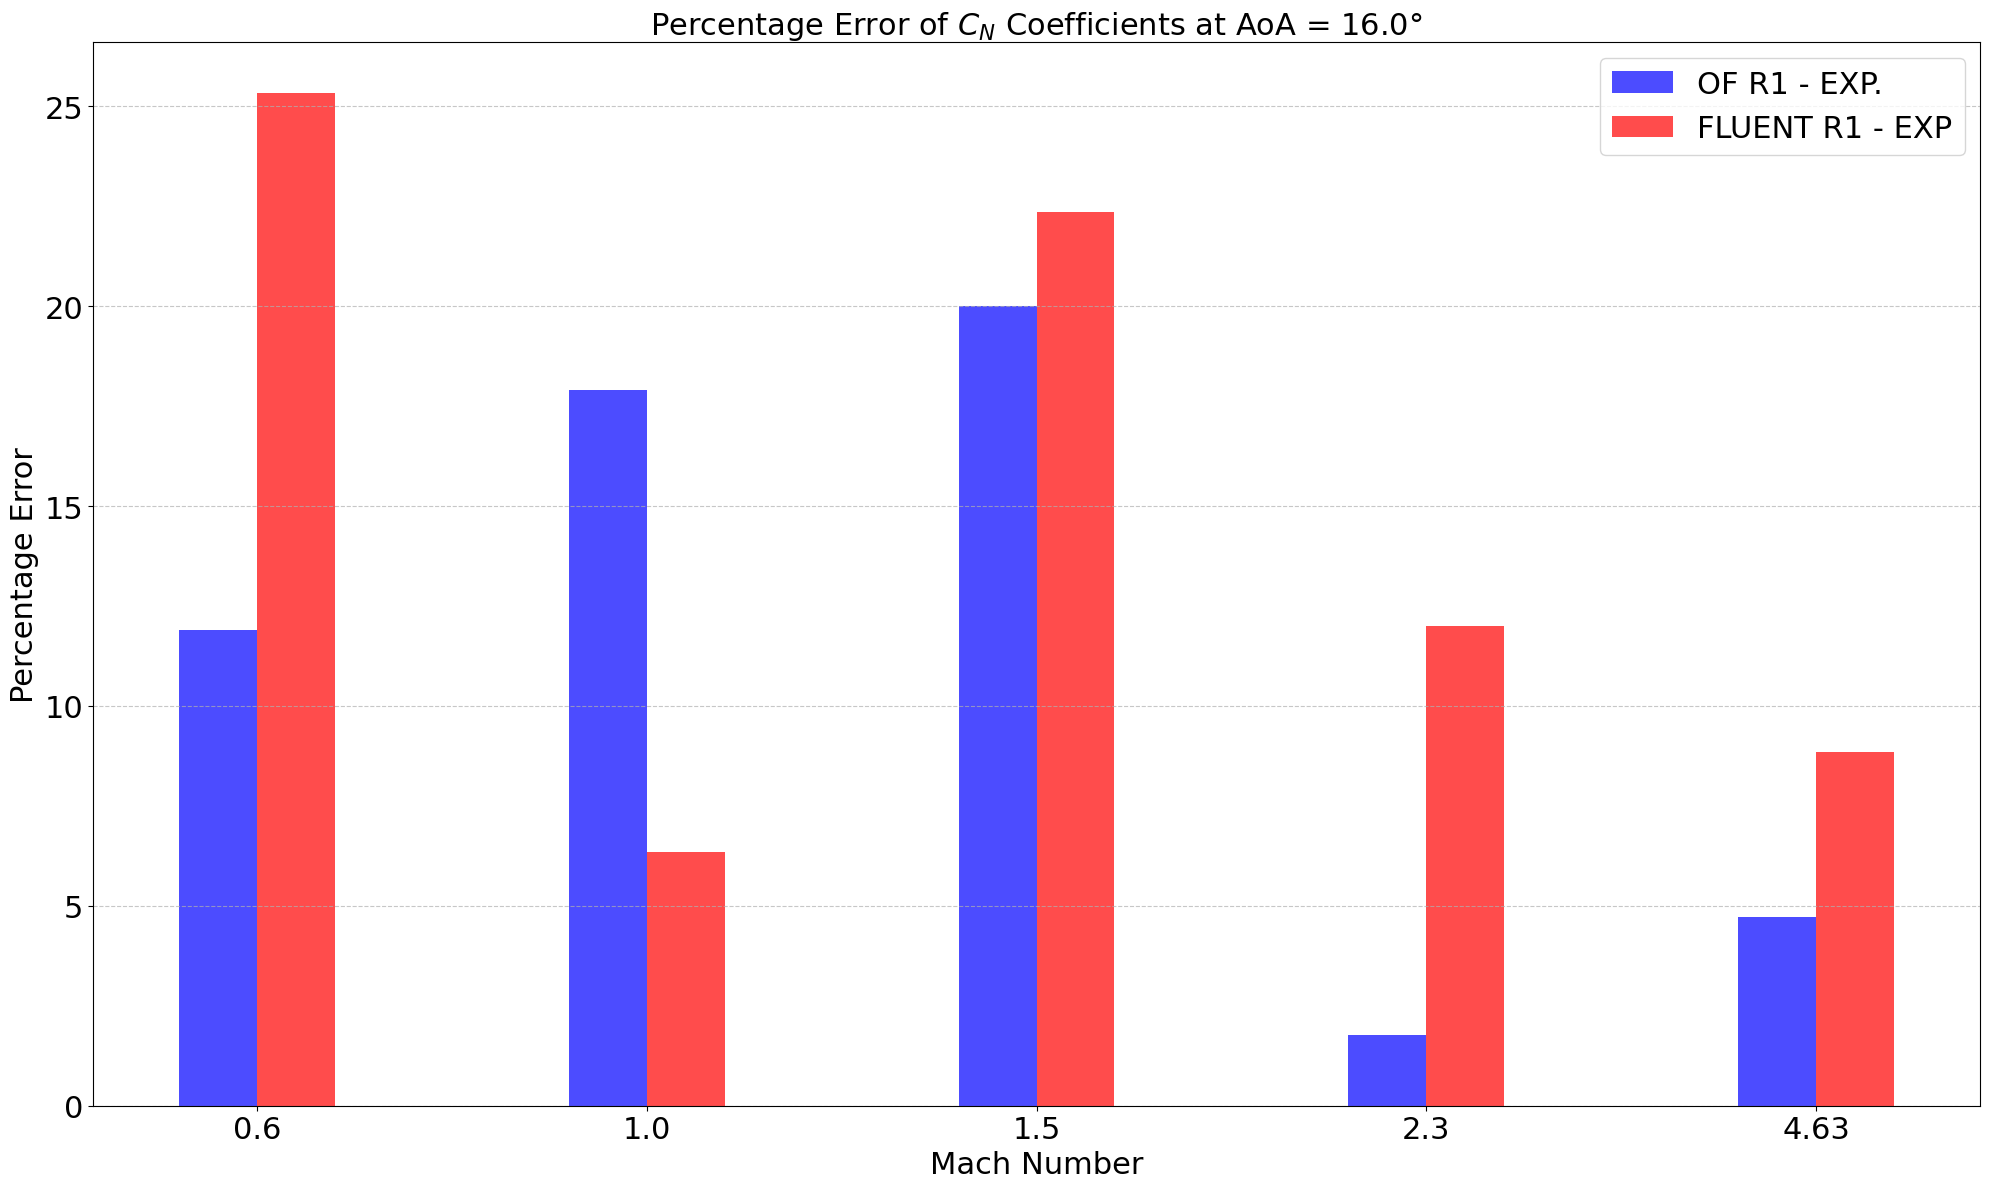

In [17]:
AoA           = 16.0
indices, data = find_aoa_index(data_CN, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_N$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_N$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [1.1301, 0.373,  0.000, 0,0], 
        1.0:  [1.5004, 0.0000,  0.000, 0,0],  
        1.5:  [1.4470, 0.0000, 0.000, 0,0],  
        2.3:  [2.98,  1.6010, 1.6456, 0,0], 
        4.63: [2.7299, 2.7299, 0.000, 0,0] 
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CN_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CN_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CN_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CN_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CN_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CN_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CN_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CN_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CN'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CN_alpha_{AoA}.png")
plt.savefig(f"CN_alpha_{AoA}.eps")
plt.savefig(f"CN_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

# Calculate percentage error margins
OF_percentage_error_R1 = np.abs(coefficients - OF_R1_rhoCentralFoam['CN_FINAL_COEFF']) / np.abs(coefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CN_FINAL_COEFF']) / np.abs(coefficients) * 100

FLUENT_percentage_error_R1 = np.abs(coefficients - coeff_R1) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(mach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

# Axes labels, title, and ticks
plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_N$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
#plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CN_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CN_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CN_PercentageError_alpha_{AoA}.pdf")
plt.show()

<div style="border: 1px solid black; padding: 20px; display: flex; justify-content: center; align-items: center; text-align: center;">
    <strong style="font-size: 24px;"> $C^{pitch}_m$ coefficient</strong>
</div>

## $C_M$ coefficient for $\alpha$ = 0$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


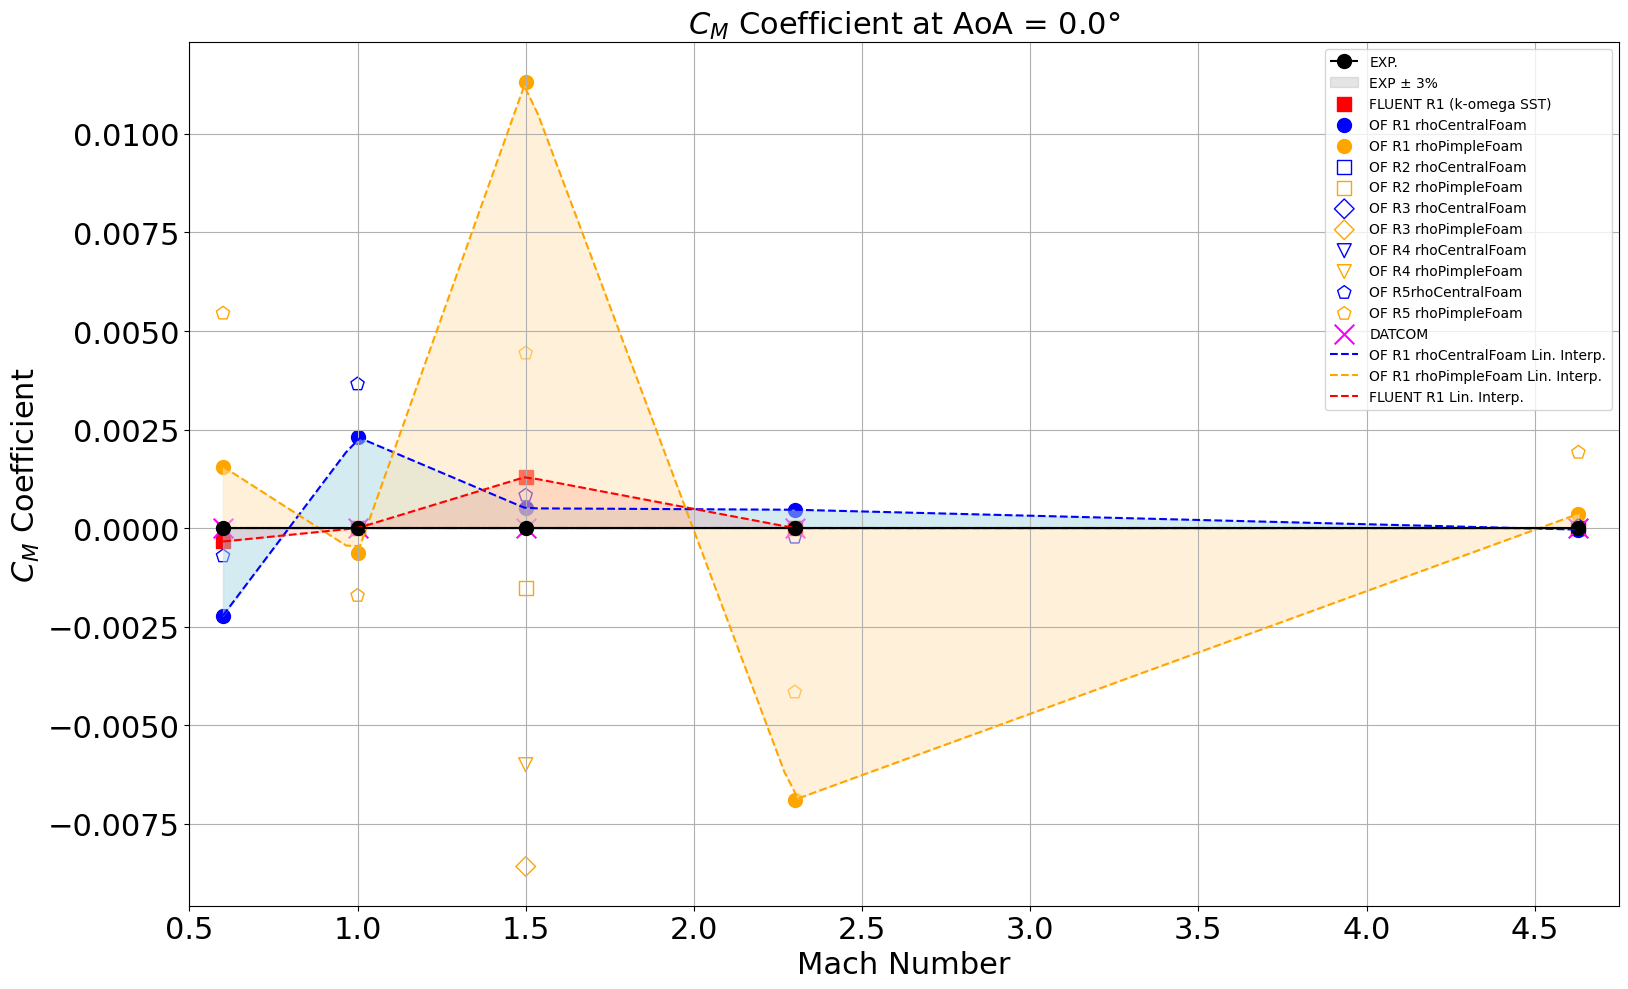

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


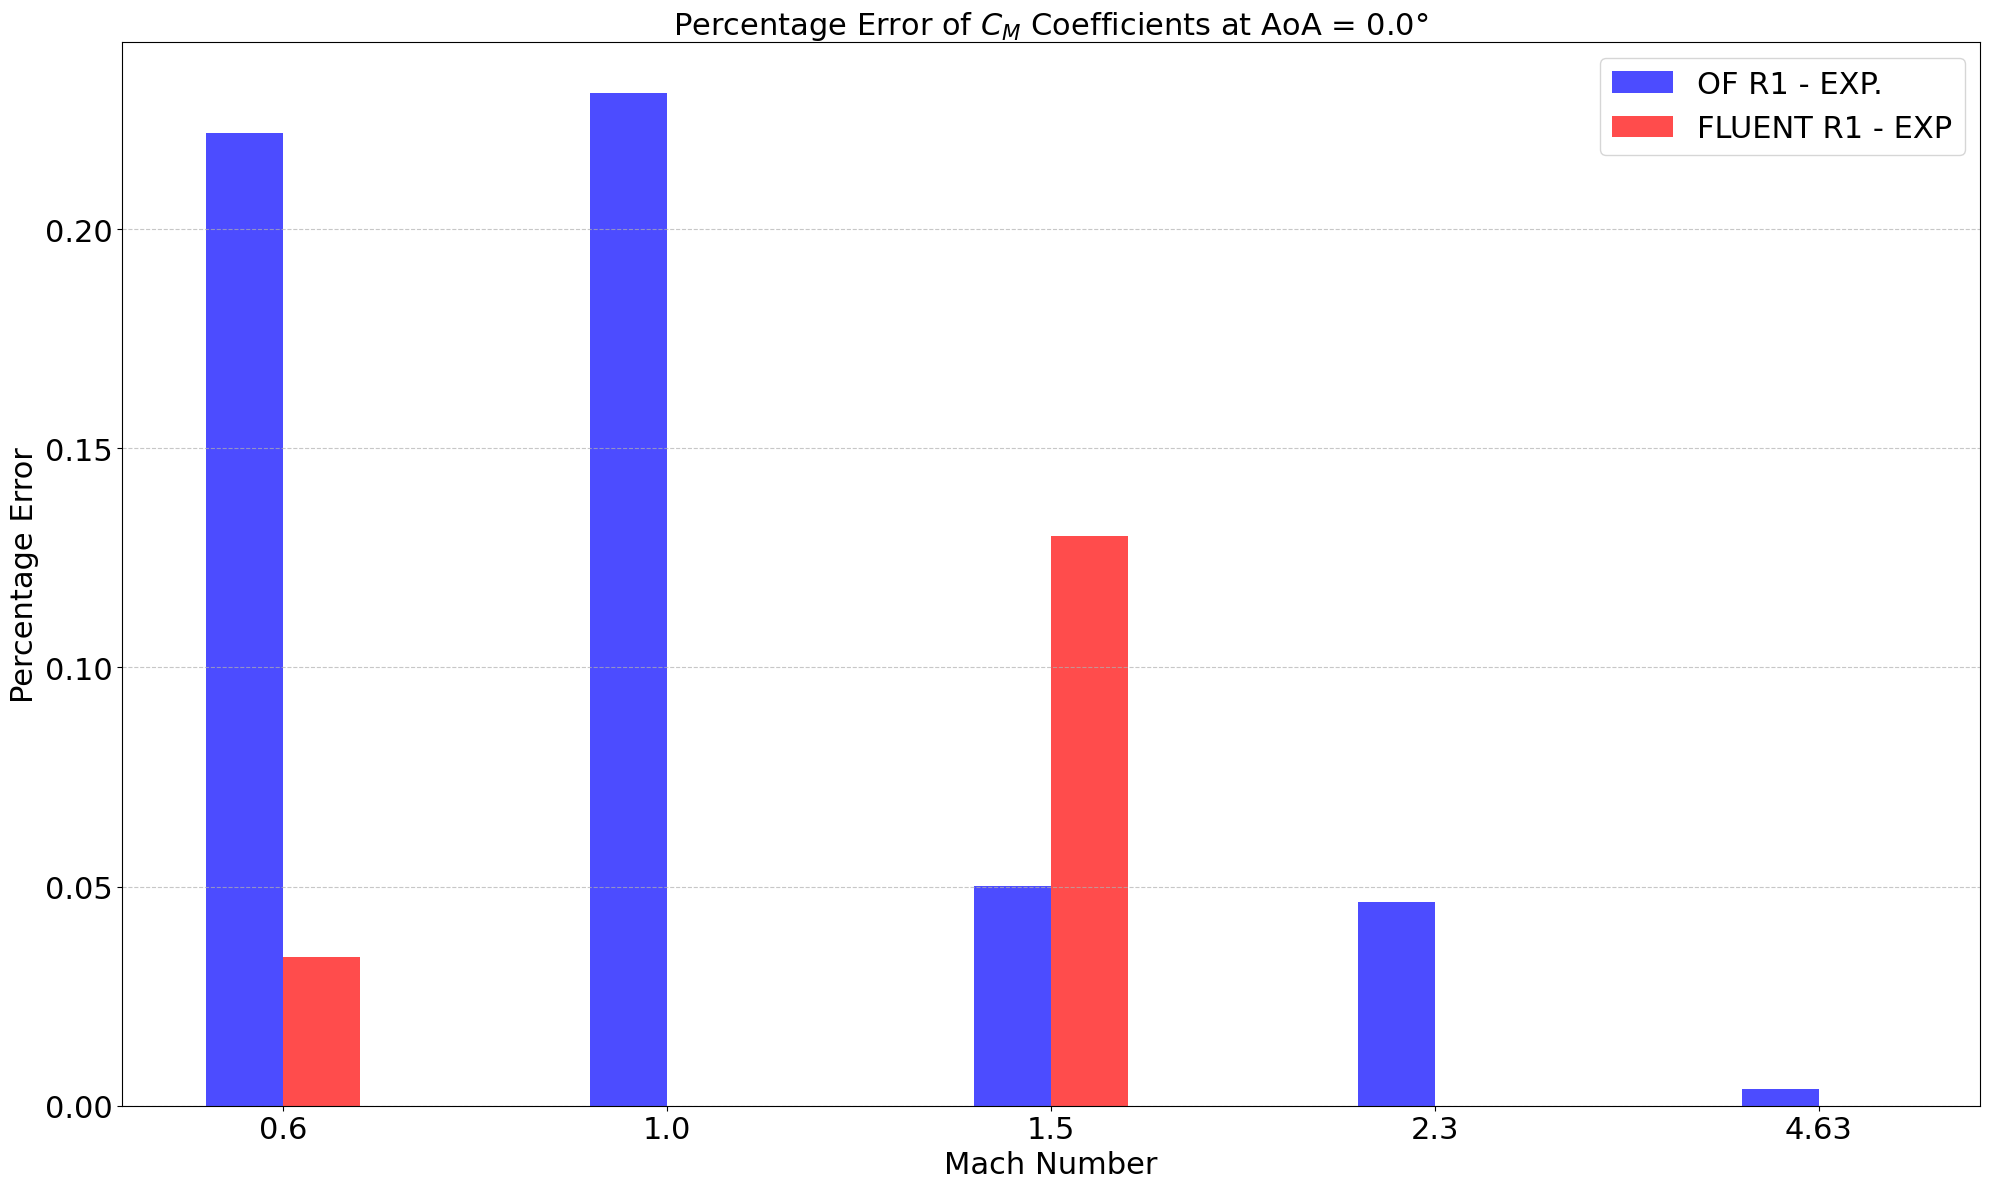

In [18]:
AoA           = 0.0
indices, data = find_aoa_index(data_CM, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_M$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_M$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [-0.00034, -0.00034,0,0,0], 
        1.0:  [0.0,0.0,0,0,0],
        1.5:  [0.0013,0.0013,0,0,0],
        2.3:  [0.0,0.0,0,0,0],
        4.63: [0.0,0.0,0,0,0] 
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CM_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CM_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CM_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CM_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CM_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CM_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CM_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CM'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CM_alpha_{AoA}.png")
plt.savefig(f"CM_alpha_{AoA}.eps")
plt.savefig(f"CM_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

eps = 1

# Calculate percentage error margins
OF_percentage_error_R1 = np.abs(coefficients - OF_R1_rhoCentralFoam['CM_FINAL_COEFF']) / np.abs(coefficients+eps) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CM_FINAL_COEFF']) / np.abs(coefficients) * 100

FLUENT_percentage_error_R1 = np.abs(coefficients - coeff_R1) / np.abs(coefficients+eps) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(mach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

# Axes labels, title, and ticks
plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_M$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
#plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CM_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CM_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CM_PercentageError_alpha_{AoA}.pdf")
plt.show()

## $C_M$ coefficient for $\alpha$ = 8$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


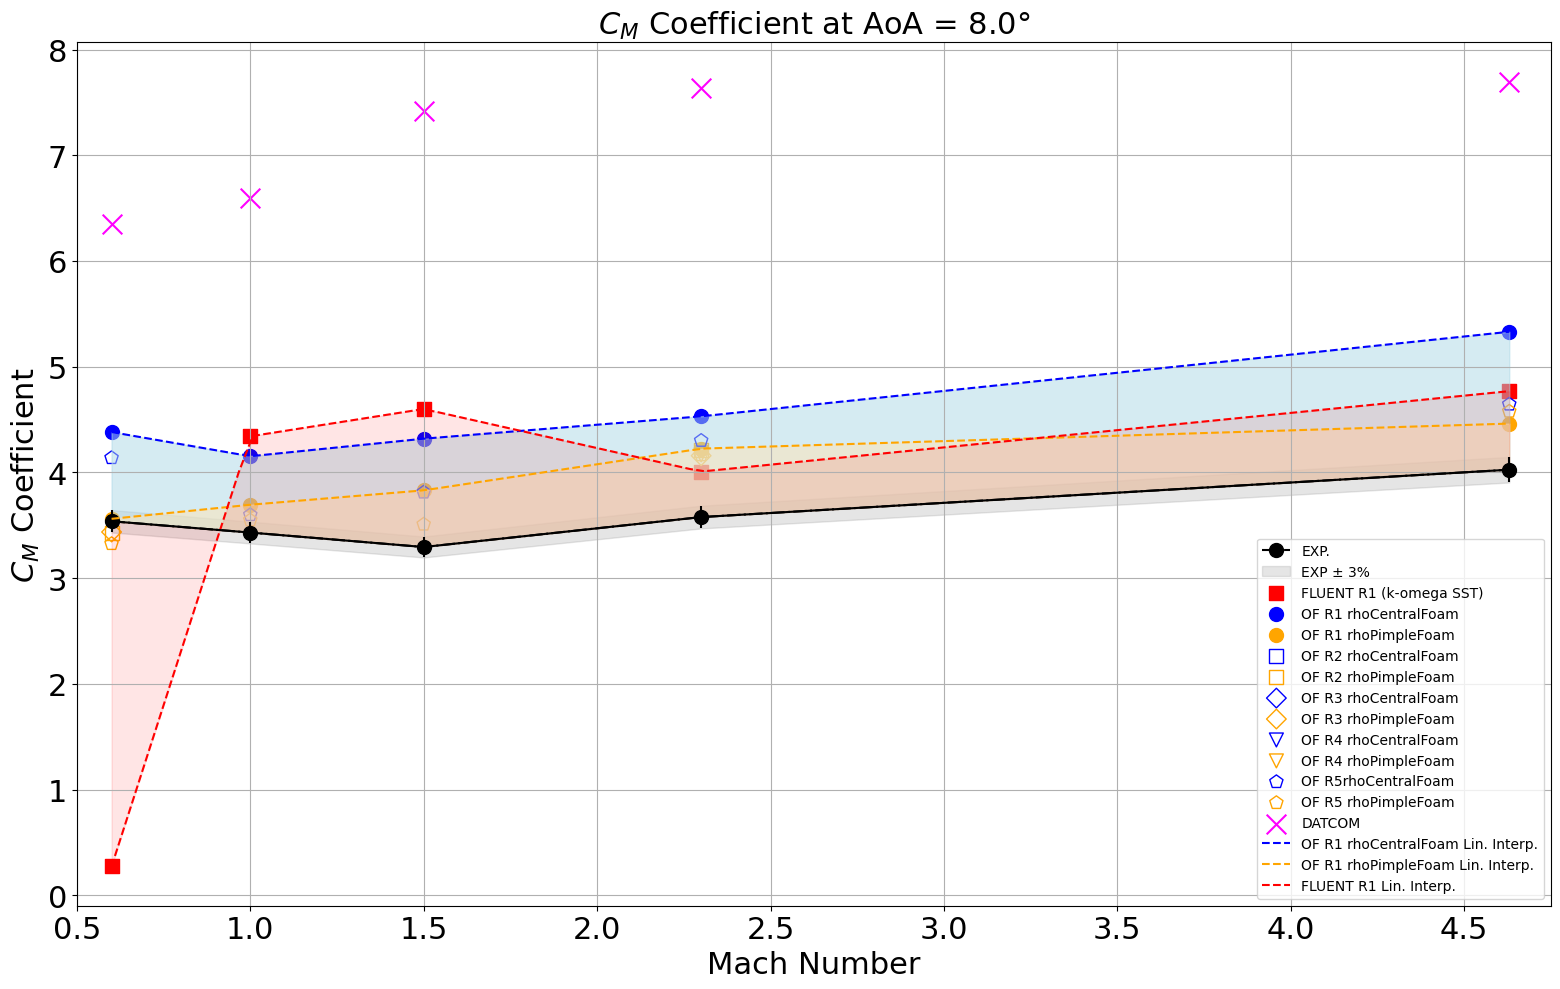

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


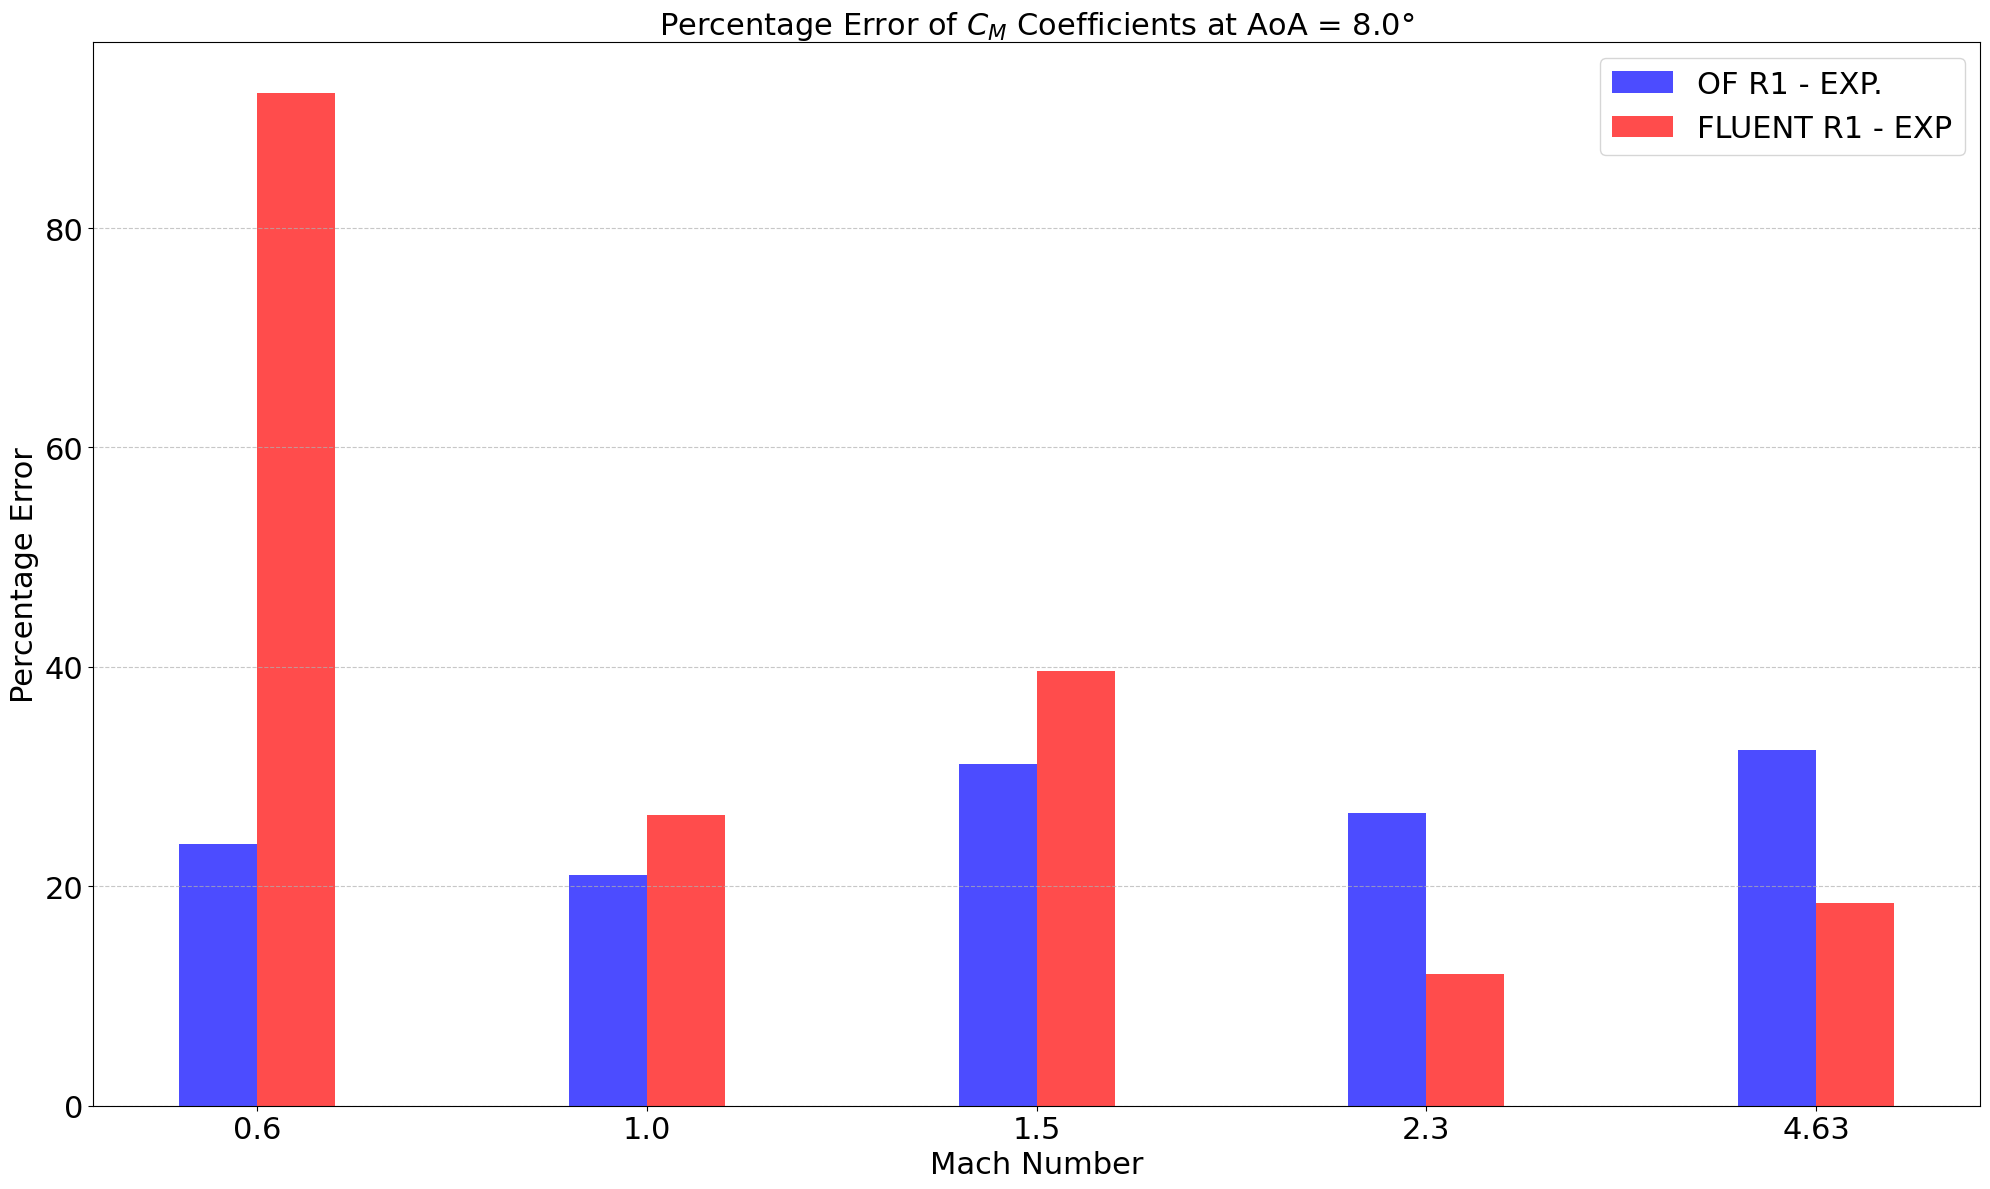

In [19]:
AoA           = 8.0
indices, data = find_aoa_index(data_CM, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_M$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_M$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [0.272,  0.373,0,0,0],  
        1.0:  [4.3412, 4.3412,0,0,0], 
        1.5:  [4.600,  4.600,0,0,0],  
        2.3:  [4.0081, 4.0081,0,0,0], 
        4.63: [4.7685, 4.7685,0,0,0] 
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CM_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CM_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CM_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CM_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CM_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CM_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CM_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CM'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CM_alpha_{AoA}.png")
plt.savefig(f"CM_alpha_{AoA}.eps")
plt.savefig(f"CM_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

# Calculate percentage error margins
OF_percentage_error_R1 = np.abs(coefficients - OF_R1_rhoCentralFoam['CM_FINAL_COEFF']) / np.abs(coefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CM_FINAL_COEFF']) / np.abs(coefficients) * 100

FLUENT_percentage_error_R1 = np.abs(coefficients - coeff_R1) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(mach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

# Axes labels, title, and ticks
plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_M$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
#plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CM_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CM_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CM_PercentageError_alpha_{AoA}.pdf")
plt.show()

## $C_M$ coefficient for $\alpha$ = 16$^\circ$ as function of Mach number

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


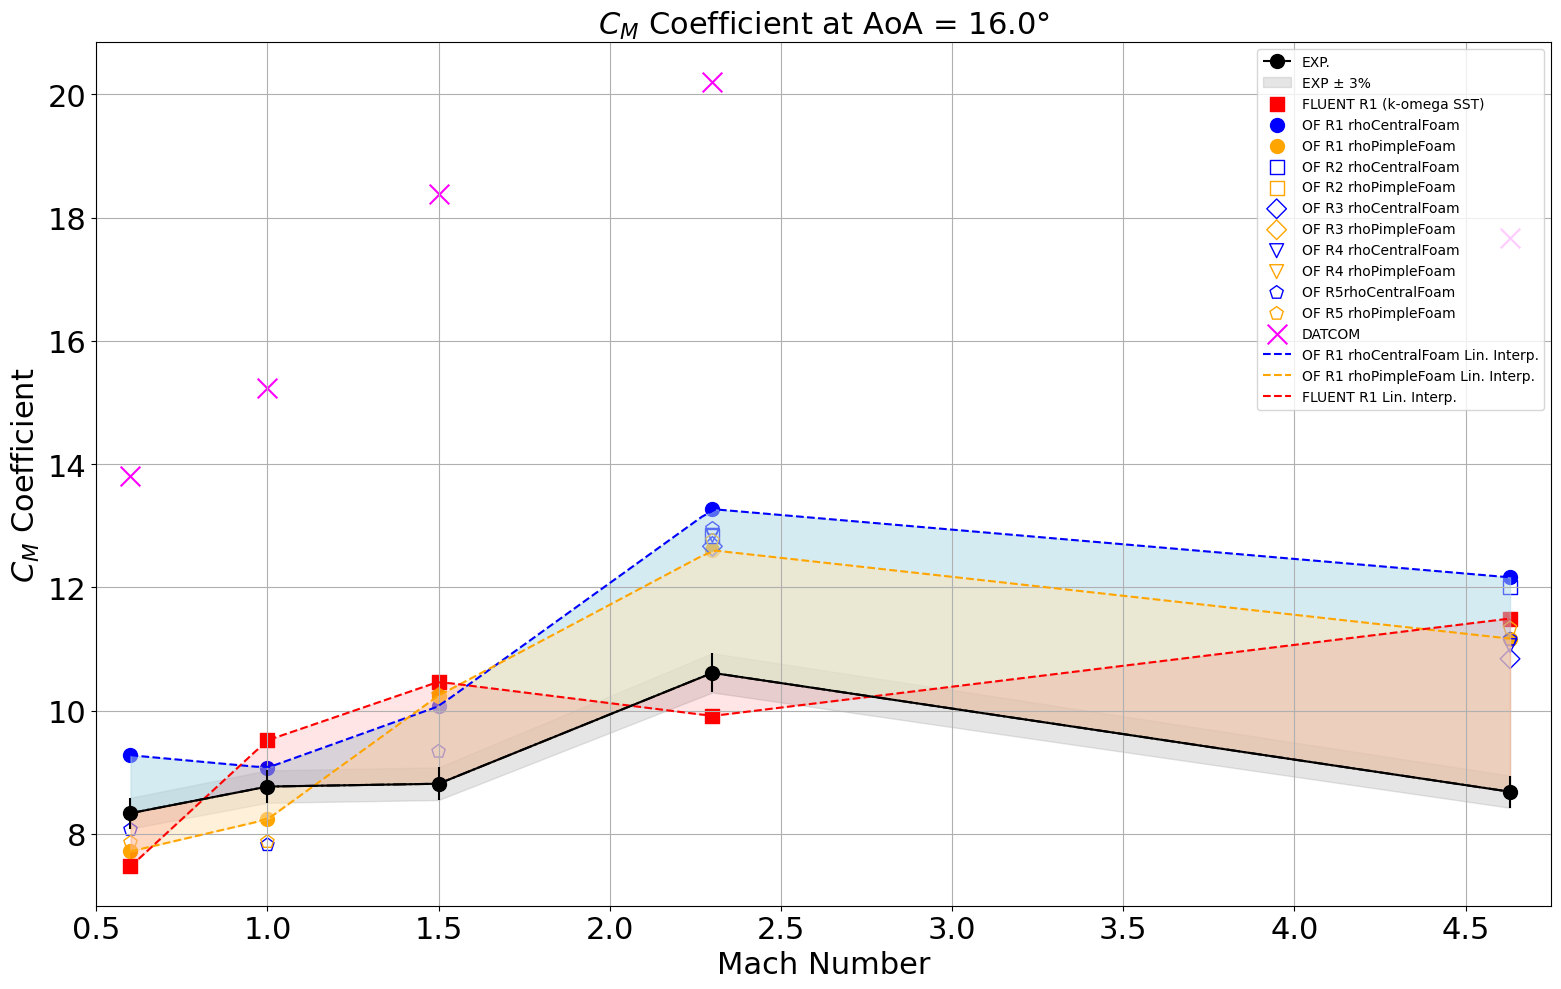

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


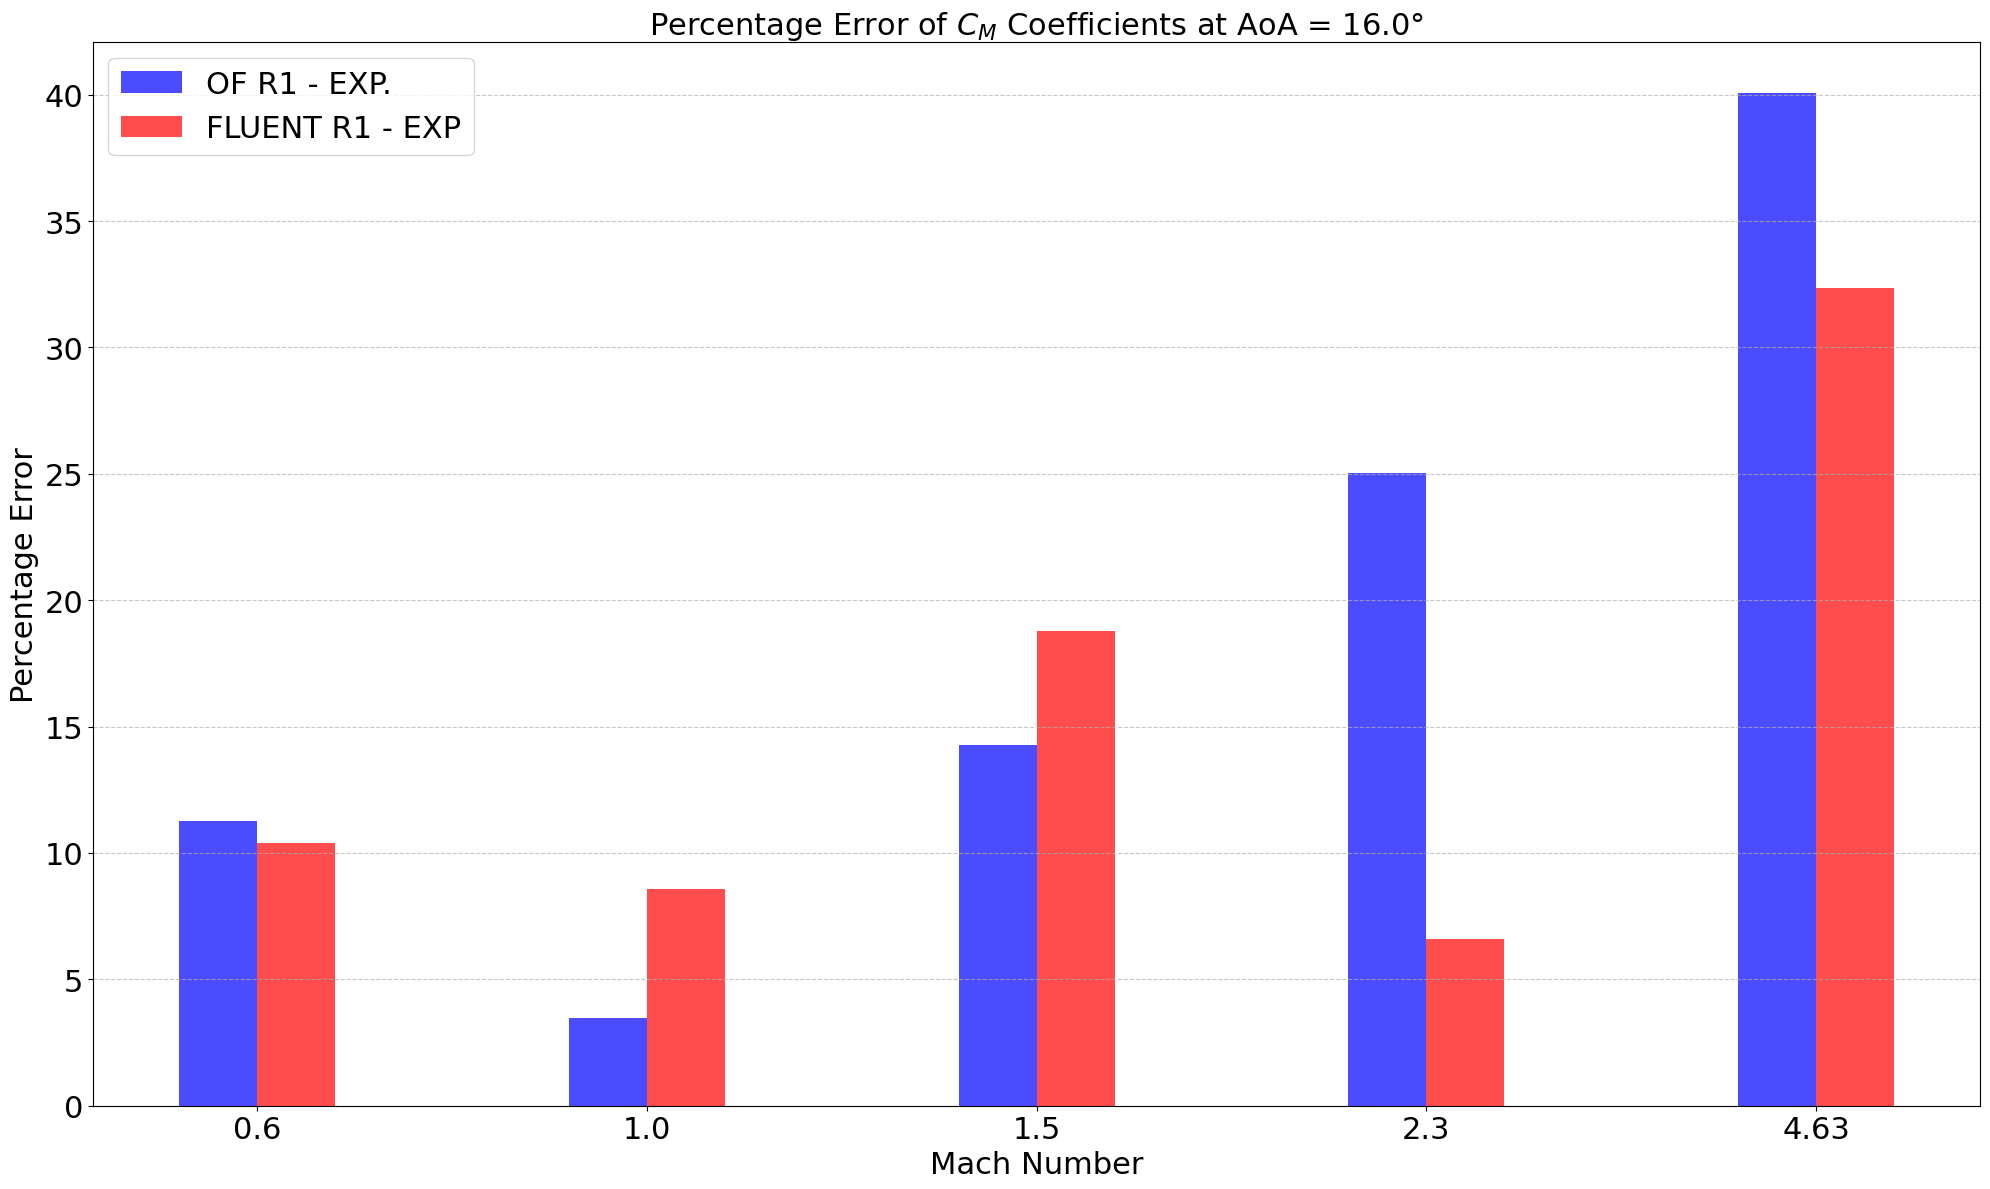

In [20]:
AoA           = 16.0
indices, data = find_aoa_index(data_CM, AoA)

# Extract column names excluding 'AoA'
columns_to_sort = data.columns.difference(['AoA'])

# Sort the columns based on Mach number, excluding the AoA column
sorted_columns = sorted(columns_to_sort, key=lambda x: float(x.split('_')[0][1:]))

# Reorder the DataFrame: keep AoA at the front and then the sorted columns
df_sorted = data[['AoA'] + sorted_columns]
data = df_sorted

mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
coefficients = data.iloc[0,1:].to_numpy()

plt.figure(figsize=(16, 10))

# Experimental results
linear_interp_exp_data = interp1d(mach_numbers, coefficients, kind='linear', fill_value='extrapolate')
plt.plot(mach_numbers, coefficients, marker='o', markersize=10, linestyle='-.', color='k', label='EXP.')
plt.errorbar(mach_numbers, coefficients, yerr = 3*coefficients/100, color='k') 

# Calculating 3% error margins
error_margin = coefficients * 0.03
plt.fill_between(mach_numbers, coefficients - error_margin, coefficients + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('$C_M$ Coefficient', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.xlim(0.5, 4.75)
plt.title(f'$C_M$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.grid(True)
plt.tight_layout()

# Numerical results from FLUENT
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [7.4704,  0.373,   0.000,0,0], 
        1.0:  [9.5183,  0.0,     0.000,0,0],
        1.5:  [10.4681, 3.6761,  0.000,0,0], 
        2.3:  [9.9133,  11.350,  11.63,0,0], 
        4.63: [11.4942, 11.4942, 0.000,0,0] 
    }
}

markers = ['s', 'D', 'v', 'p', 'h', "d"]
colors = ['red', 'magenta', 'red', 'green', 'magenta', 'grey']

for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
    mach_numbers_model = list(model_data.keys())
    coeff_R1 = [values[0] for values in model_data.values()]
    coeff_R2 = [values[1] for values in model_data.values()]
    coeff_R3 = [values[2] for values in model_data.values()]
    coeff_R4 = [values[3] for values in model_data.values()]
    coeff_R5 = [values[4] for values in model_data.values()]

    plt.scatter(mach_numbers_model, coeff_R1, marker=markers, s=100, label=f'FLUENT R1 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R2, marker=markers, s=100, label=f'FLUENT R2 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R3, marker=markers, s=100, label=f'FLUENT R3 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R4, marker=markers, s=100, label=f'FLUENT R4 ({model_name})', color=color)
    #plt.scatter(mach_numbers_model, coeff_R5, marker=markers, s=100, label=f'FLUENT R5 ({model_name})', color=color)

    linear_interp_FLUENT_R1 = interp1d(mach_numbers_model, coeff_R1, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R2 = interp1d(mach_numbers_model, coeff_R2, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R3 = interp1d(mach_numbers_model, coeff_R3, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R4 = interp1d(mach_numbers_model, coeff_R4, kind='linear', fill_value='extrapolate')
    #linear_interp_FLUENT_R5 = interp1d(mach_numbers_model, coeff_R5, kind='linear', fill_value='extrapolate')

# Numerical results from OpenFOAM
OF_R1_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoCentralFoam')]
OF_R1_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R1') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R2_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoCentralFoam')]
OF_R2_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R2') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R3_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoCentralFoam')]
OF_R3_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R3') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R4_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoCentralFoam')]
OF_R4_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R4') & (report['Solver'] == 'rhoPimpleFoam')]

OF_R5_rhoCentralFoam = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoCentralFoam')]
OF_R5_rhoPimpleFoam  = report[(report['AoA'] == AoA) & (report['Grid_Refinement'] == 'R5') & (report['Solver'] == 'rhoPimpleFoam')]

linear_interp_OF_R1_rhoCentralFoam = interp1d(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CM_FINAL_COEFF'], kind='linear', fill_value='extrapolate')
linear_interp_OF_R1_rhoPimpleFoam  = interp1d(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CM_FINAL_COEFF'],  kind='linear', fill_value='extrapolate')

plt.scatter(OF_R1_rhoCentralFoam['Mach'], OF_R1_rhoCentralFoam['CM_FINAL_COEFF'], marker='o', s=100, linestyle='-', color='blue',   label='OF R1 rhoCentralFoam')
plt.scatter(OF_R1_rhoPimpleFoam['Mach'],  OF_R1_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='o', s=100, linestyle='-', color='orange', label='OF R1 rhoPimpleFoam')

plt.scatter(OF_R2_rhoCentralFoam['Mach'], OF_R2_rhoCentralFoam['CM_FINAL_COEFF'], marker='s', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R2 rhoCentralFoam')
plt.scatter(OF_R2_rhoPimpleFoam['Mach'],  OF_R2_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='s', facecolors='none', s=100, linestyle='-', color='orange', label='OF R2 rhoPimpleFoam')

plt.scatter(OF_R3_rhoCentralFoam['Mach'], OF_R3_rhoCentralFoam['CM_FINAL_COEFF'], marker='D', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R3 rhoCentralFoam')
plt.scatter(OF_R3_rhoPimpleFoam['Mach'],  OF_R3_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='D', facecolors='none', s=100, linestyle='-', color='orange', label='OF R3 rhoPimpleFoam')

plt.scatter(OF_R4_rhoCentralFoam['Mach'], OF_R4_rhoCentralFoam['CM_FINAL_COEFF'], marker='v', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R4 rhoCentralFoam')
plt.scatter(OF_R4_rhoPimpleFoam['Mach'],  OF_R4_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='v', facecolors='none', s=100, linestyle='-', color='orange', label='OF R4 rhoPimpleFoam')

plt.scatter(OF_R5_rhoCentralFoam['Mach'], OF_R5_rhoCentralFoam['CM_FINAL_COEFF'], marker='p', facecolors='none', s=100, linestyle='-', color='blue',   label='OF R5rhoCentralFoam')
plt.scatter(OF_R5_rhoPimpleFoam['Mach'],  OF_R5_rhoPimpleFoam['CM_FINAL_COEFF'],  marker='p', facecolors='none', s=100, linestyle='-', color='orange', label='OF R5 rhoPimpleFoam')

# Numerical results from DATCOM
datcom_data = datcom[datcom['ALPHA'] == AoA]
plt.scatter(datcom_data['MACH'],  datcom_data['CM'],  marker='x', s=200, linestyle='-', color='magenta', label='DATCOM')

# Create a new range of Mach numbers for interpolation
mach_numbers_fine = np.linspace(min(mach_numbers), max(mach_numbers), num=100)

# Perform the interpolation
linear_interp_exp_data_values             = linear_interp_exp_data(mach_numbers_fine)
linear_interp_OF_R1_rhoCentralFoam_values = linear_interp_OF_R1_rhoCentralFoam(mach_numbers_fine)
linear_interp_OF_R1_rhoPimpleFoam_values  = linear_interp_OF_R1_rhoPimpleFoam(mach_numbers_fine)
linear_interp_FLUENT_R1_values            = linear_interp_FLUENT_R1(mach_numbers_fine)

#plt.plot(mach_numbers_fine, linear_interp_exp_data_values, label='EXP. Lin. Interp.', linestyle='--', color='black')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoCentralFoam_values, label='OF R1 rhoCentralFoam Lin. Interp.', linestyle='--', color='blue')
plt.plot(mach_numbers_fine, linear_interp_OF_R1_rhoPimpleFoam_values,  label='OF R1 rhoPimpleFoam Lin. Interp.',  linestyle='--', color='orange')
plt.plot(mach_numbers_fine, linear_interp_FLUENT_R1_values,            label='FLUENT R1 Lin. Interp.',            linestyle='--', color='red')

plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoCentralFoam_values, color='lightblue', alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_OF_R1_rhoPimpleFoam_values,  color='moccasin',  alpha=0.5)
plt.fill_between(mach_numbers_fine, linear_interp_exp_data_values, linear_interp_FLUENT_R1_values,            color='red',       alpha=0.1)

plt.legend()
plt.savefig(f"CM_alpha_{AoA}.png")
plt.savefig(f"CM_alpha_{AoA}.eps")
plt.savefig(f"CM_alpha_{AoA}.pdf") 
plt.show()

############
# Bar plot #
############

# Calculate percentage error margins
OF_percentage_error_R1 = np.abs(coefficients - OF_R1_rhoCentralFoam['CM_FINAL_COEFF']) / np.abs(coefficients) * 100
#OF_percentage_error_R5 = np.abs(coefficients - OF_R5_rhoCentralFoam['CM_FINAL_COEFF']) / np.abs(coefficients) * 100

FLUENT_percentage_error_R1 = np.abs(coefficients - coeff_R1) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R2 = np.abs(coefficients - coeff_R2) / np.abs(coefficients) * 100
#FLUENT_percentage_error_R3 = np.abs(coefficients - coeff_R3) / np.abs(coefficients) * 100

# Plotting setup for percentage error margins
plt.figure(figsize=(20, 12))
width = 0.2                      # Width of the bars
x = np.arange(len(mach_numbers)) # Label locations

# Create bar plots for percentage error margins
barsR1OF = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF R1 - EXP.', color='blue', alpha=0.7)
#barsR5OF = plt.bar(x - width/4, OF_percentage_error_R5, width, label='OF (R5) - EXP Margin (%)', color='green', alpha=0.7)

barsR1F  = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT R1 - EXP', color='red', alpha=0.7)
#barsR2F  = plt.bar(x + 5*width/4, FLUENT_percentage_error_R2, width, label='FLUENT (R2) - EXP Margin (%)', color='violet', alpha=0.7)
#barsR3F  = plt.bar(x + 8*width/4, FLUENT_percentage_error_R3, width, label='FLUENT (R3) - EXP Margin (%)', color='gray', alpha=0.7)

# Axes labels, title, and ticks
plt.xlabel('Mach Number', fontsize=22)
plt.ylabel('Percentage Error', fontsize=22)
plt.title(f'Percentage Error of $C_M$ Coefficients at AoA = {AoA}°', fontsize=22)
plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tick_params(axis='both', which='minor', labelsize=22)
#plt.title(f'$C_A$ Coefficient at AoA = {AoA}°', fontsize=22)
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"CM_PercentageError_alpha_{AoA}.png")
plt.savefig(f"CM_PercentageError_alpha_{AoA}.eps")
plt.savefig(f"CM_PercentageError_alpha_{AoA}.pdf")
plt.show()